# We will try tracking the hands with just 6 landmarks, which will be a 6 x 3 x 2 = 36 length vector for each time step. 

In [5]:
import cv2, os 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [6]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [7]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)
    
def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [8]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :12] 
        Y_locations = X[:,  12:24] 
        Z_locations = X[:, 24:]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:,  12:24].assign(X[:,  12:24] + mask * tf.ones_like(X[:,  12:24]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:,  12:24].assign(X[:,  12:24] - mask * tf.ones_like(X[:,  12:24]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :12].assign(X[:, :12] + mask * tf.ones_like(X[:, :12]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :12].assign(X[:, :12] - mask * tf.ones_like(X[:, :12]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move far
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 24:].assign(X[:, 24:] + mask * tf.ones_like(X[:, 24:]) * move_far)
        else: 
            # move close 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 24:].assign(X[:, 24:] - mask * tf.ones_like(X[:, 24:]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  
        

In [9]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [10]:
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [11]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = "extrapolate")
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [12]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (No Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (No Aug)")
    plt.show()

In [13]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], []
META_RESULT_MATRIX = [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    """adds the training & validation accuracy, precision, recall, and F1 for each of the folds to a meta matrix"""
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        # for each fold 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))


        # accuracy: 0.7625 - precision: 0.7442 - recall: 0.8000 - val_loss: 0.6086 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0

        training_accuracy = history.history['accuracy'][-1]
        validation_accuracy = history.history['val_accuracy'][-1]
        training_precision = history.history['precision'][-1]
        validation_precision = history.history['val_precision'][-1]
        training_recall = history.history['recall'][-1]
        validation_recall = history.history['val_recall'][-1]
        training_f1 = 2 * training_precision * training_recall / (training_precision + training_recall)
        validation_f1 = 2 * validation_precision * validation_recall / (validation_precision + validation_recall)

        # add to meta matrix
        META_RESULT_MATRIX.append([training_accuracy, training_precision, training_recall, training_f1, validation_accuracy, validation_precision, validation_recall, validation_f1])

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [14]:
# don't shuffle  

import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y


In [15]:
def f1(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [16]:
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences=False, input_shape = (None, 36)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

    return model

In [17]:
original_X = X
original_Y = y 

2021-11-02 23:15:17.560602: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/75
1/3 [=========>....................] - ETA: 0s - loss: 0.6855 - accuracy: 0.5312 - precision: 0.5000 - recall: 0.8667

2021-11-02 23:15:18.285720: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


3/3 [==============================] - 1s 169ms/step - loss: 0.7313 - accuracy: 0.5125 - precision: 0.5484 - recall: 0.4048 - val_loss: 0.6766 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 176ms/step - loss: 0.6627 - accuracy: 0.5750 - precision: 0.5526 - recall: 1.0000 - val_loss: 0.6649 - val_accuracy: 0.4500 - val_precision: 0.4211 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 198ms/step - loss: 0.6423 - accuracy: 0.5875 - precision: 0.5616 - recall: 0.9762 - val_loss: 0.6979 - val_accuracy: 0.3500 - val_precision: 0.3077 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 166ms/step - loss: 0.5967 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.7143 - val_loss: 0.7212 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.3750
Epoch 5/75
3/3 [==============================] - 0s 168ms/step - loss: 0.5868 - accuracy: 0.7125 - precision: 0.7111 - rec

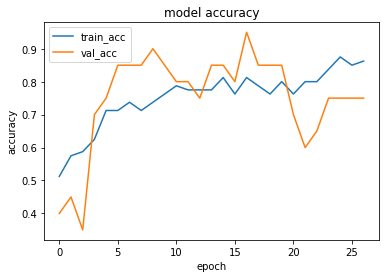

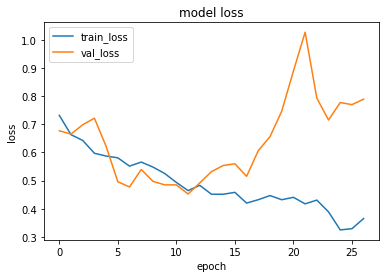

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
1it [00:00, 3302.60it/s]


prediction for video armflapping_1.mov is [[0.46362978]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_3.mov is [[0.8501378]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.7743003]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.37501135]]


1it [00:00, 17476.27it/s]


prediction for video control_2.mov is [[0.3047878]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.31984806]]
Epoch 1/75
3/3 [==============================] - 1s 180ms/step - loss: 0.7121 - accuracy: 0.4875 - precision: 0.5000 - recall: 0.7317 - val_loss: 0.6219 - val_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 166ms/step - loss: 0.6682 - accuracy: 0.6875 - precision: 0.8636 - recall: 0.4634 - val_loss: 0.5951 - val_accuracy: 0.7500 - val_precision: 0.6429 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 169ms/step - loss: 0.6354 - accuracy: 0.6250 - precision: 0.6000 - recall: 0.8049 - val_loss: 0.6148 - val_accuracy: 0.7000 - val_precision: 0.6000 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6198 - accuracy: 0.6500 - precision: 0.6182 - recall: 0.8293 - val_loss: 0.4945 - val_accuracy: 0.7500 - val_precision: 0.6429 - val_recall: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 156ms/

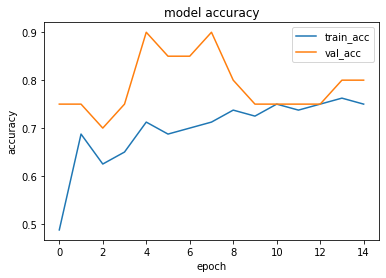

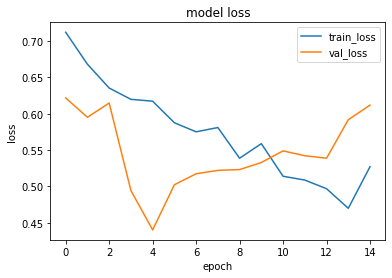

1it [00:00, 15827.56it/s]


prediction for video armflapping_1.mov is [[0.50132215]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_3.mov is [[0.7542771]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.68966645]]


1it [00:00, 16980.99it/s]


prediction for video control_1.mov is [[0.20056304]]


1it [00:00, 16644.06it/s]


prediction for video control_2.mov is [[0.22821933]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.2142263]]
Epoch 1/75
3/3 [==============================] - 0s 140ms/step - loss: 0.7643 - accuracy: 0.5250 - precision: 0.5082 - recall: 0.7949 - val_loss: 0.6760 - val_accuracy: 0.6000 - val_precision: 0.6667 - val_recall: 0.5455
Epoch 2/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6518 - accuracy: 0.7375 - precision: 0.8462 - recall: 0.5641 - val_loss: 0.6657 - val_accuracy: 0.5000 - val_precision: 0.5294 - val_recall: 0.8182
Epoch 3/75
3/3 [==============================] - 1s 211ms/step - loss: 0.6403 - accuracy: 0.6250 - precision: 0.5714 - recall: 0.9231 - val_loss: 0.6660 - val_accuracy: 0.5500 - val_precision: 0.5500 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6231 - accuracy: 0.5750 - precision: 0.5352 - recall: 0.9744 - val_loss: 0.6340 - val_accuracy: 0.6500 - val_precision: 0.6667 - val_recall: 0.7273
Epoch 5/75
3/3 [==============================] - 0s 133ms/s

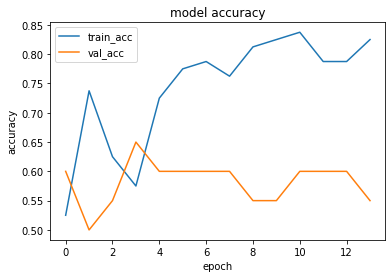

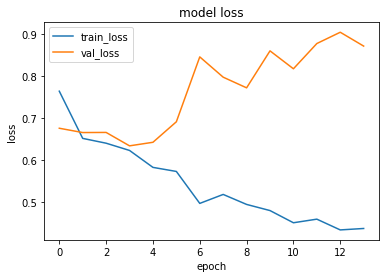

1it [00:00, 13148.29it/s]


prediction for video armflapping_1.mov is [[0.25261652]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.44438112]]


1it [00:00, 14027.77it/s]


prediction for video armflapping_2.mov is [[0.55775017]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.15082806]]


1it [00:00, 15196.75it/s]


prediction for video control_2.mov is [[0.1387802]]


1it [00:00, 13842.59it/s]


prediction for video control_3.mov is [[0.13563663]]
Epoch 1/75
3/3 [==============================] - 0s 142ms/step - loss: 0.7098 - accuracy: 0.5875 - precision: 0.5345 - recall: 0.8378 - val_loss: 0.6775 - val_accuracy: 0.4500 - val_precision: 1.0000 - val_recall: 0.1538
Epoch 2/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6883 - accuracy: 0.5875 - precision: 1.0000 - recall: 0.1081 - val_loss: 0.5872 - val_accuracy: 0.8500 - val_precision: 0.8571 - val_recall: 0.9231
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6503 - accuracy: 0.6375 - precision: 0.5800 - recall: 0.7838 - val_loss: 0.5299 - val_accuracy: 0.8000 - val_precision: 0.8462 - val_recall: 0.8462
Epoch 4/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6181 - accuracy: 0.6750 - precision: 0.6279 - recall: 0.7297 - val_loss: 0.5404 - val_accuracy: 0.9000 - val_precision: 1.0000 - val_recall: 0.8462
Epoch 5/75
3/3 [==============================] - 0s 135ms/

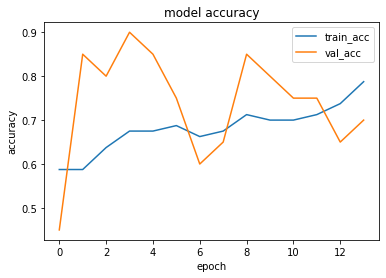

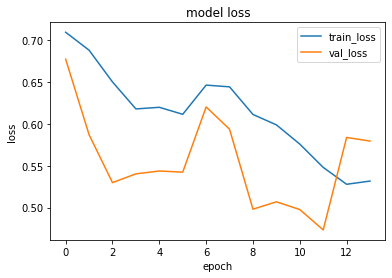

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.2757945]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.25444993]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_2.mov is [[0.55880636]]


1it [00:00, 16912.52it/s]


prediction for video control_1.mov is [[0.2520089]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.24039266]]


1it [00:00, 13888.42it/s]


prediction for video control_3.mov is [[0.23510164]]
Epoch 1/75
3/3 [==============================] - 0s 128ms/step - loss: 0.7122 - accuracy: 0.5875 - precision: 0.6667 - recall: 0.3902 - val_loss: 0.7213 - val_accuracy: 0.5500 - val_precision: 0.5000 - val_recall: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6450 - accuracy: 0.6125 - precision: 0.5781 - recall: 0.9024 - val_loss: 0.7664 - val_accuracy: 0.5000 - val_precision: 0.4667 - val_recall: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 139ms/step - loss: 0.5967 - accuracy: 0.7625 - precision: 0.7115 - recall: 0.9024 - val_loss: 0.8132 - val_accuracy: 0.4500 - val_precision: 0.4000 - val_recall: 0.4444
Epoch 4/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6245 - accuracy: 0.6500 - precision: 0.6585 - recall: 0.6585 - val_loss: 0.8142 - val_accuracy: 0.5500 - val_precision: 0.5000 - val_recall: 0.2222
Epoch 5/75
3/3 [==============================] - 0s 143ms/

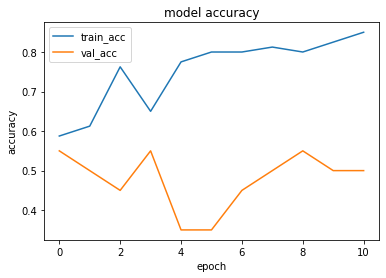

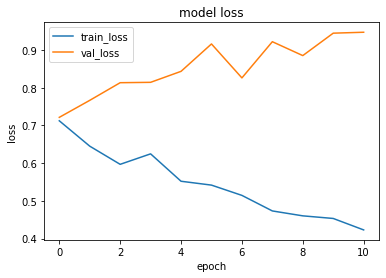

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.16795108]]


1it [00:00, 12985.46it/s]


prediction for video armflapping_3.mov is [[0.19926727]]


1it [00:00, 10512.04it/s]


prediction for video armflapping_2.mov is [[0.65309]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.13975763]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.13395584]]


1it [00:00, 14074.85it/s]


prediction for video control_3.mov is [[0.13366723]]


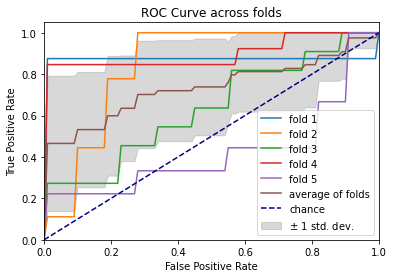

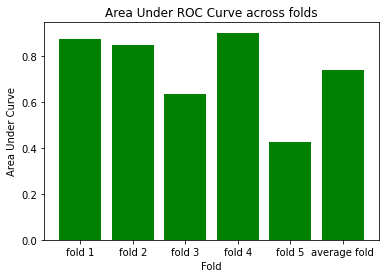

Epoch 1/75
3/3 [==============================] - 1s 211ms/step - loss: 0.6925 - accuracy: 0.4375 - precision: 0.4717 - recall: 0.5952 - val_loss: 0.6790 - val_accuracy: 0.7000 - val_precision: 0.5833 - val_recall: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6680 - accuracy: 0.6000 - precision: 0.5758 - recall: 0.9048 - val_loss: 0.6538 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 0.7500
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6108 - accuracy: 0.7250 - precision: 0.7632 - recall: 0.6905 - val_loss: 0.6280 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 142ms/step - loss: 0.5726 - accuracy: 0.7250 - precision: 0.8333 - recall: 0.5952 - val_loss: 0.5699 - val_accuracy: 0.8000 - val_precision: 0.7000 - val_recall: 0.8750
Epoch 5/75
3/3 [==============================] - 0s 142ms/step - loss: 0.5956 - accuracy: 0.6750 - precision: 0

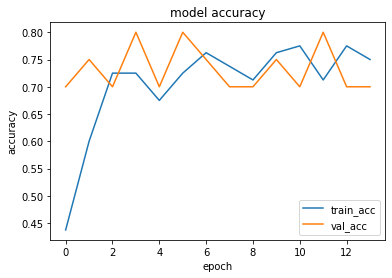

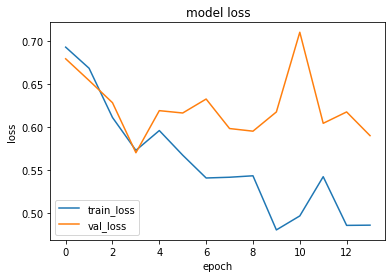

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.48901615]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.59265167]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_2.mov is [[0.6517199]]


1it [00:00, 14122.24it/s]


prediction for video control_1.mov is [[0.3496821]]


1it [00:00, 14027.77it/s]


prediction for video control_2.mov is [[0.2999069]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.29512906]]
Epoch 1/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6425 - accuracy: 0.6750 - precision: 0.6458 - recall: 0.7750 - val_loss: 0.6248 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 144ms/step - loss: 0.5866 - accuracy: 0.7375 - precision: 0.7568 - recall: 0.7000 - val_loss: 0.5783 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6037 - accuracy: 0.7375 - precision: 0.7209 - recall: 0.7750 - val_loss: 0.7810 - val_accuracy: 0.5500 - val_precision: 0.5333 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6123 - accuracy: 0.7000 - precision: 0.6481 - recall: 0.8750 - val_loss: 0.5854 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 5/75
3/3 [==============================] - 0s 151ms/

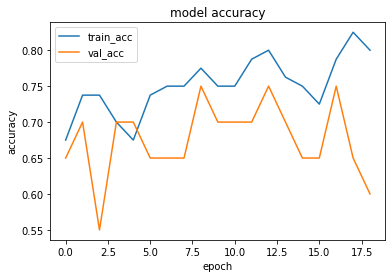

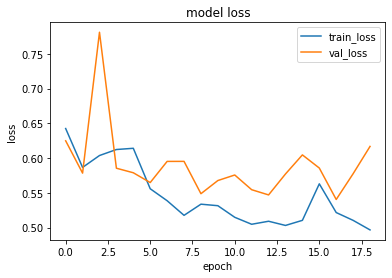

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.49884224]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_3.mov is [[0.7684369]]


1it [00:00, 12985.46it/s]


prediction for video armflapping_2.mov is [[0.7121539]]


1it [00:00, 16448.25it/s]


prediction for video control_1.mov is [[0.30475265]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.25962007]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.24636781]]
Epoch 1/75
3/3 [==============================] - 1s 178ms/step - loss: 0.7572 - accuracy: 0.5375 - precision: 0.5211 - recall: 0.9250 - val_loss: 0.6880 - val_accuracy: 0.6000 - val_precision: 0.5833 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6518 - accuracy: 0.6750 - precision: 0.7500 - recall: 0.5250 - val_loss: 0.6867 - val_accuracy: 0.5500 - val_precision: 0.5714 - val_recall: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 167ms/step - loss: 0.6325 - accuracy: 0.6375 - precision: 0.7391 - recall: 0.4250 - val_loss: 0.6625 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 167ms/step - loss: 0.5894 - accuracy: 0.6750 - precision: 0.6250 - recall: 0.8750 - val_loss: 0.6553 - val_accuracy: 0.7000 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 166ms/

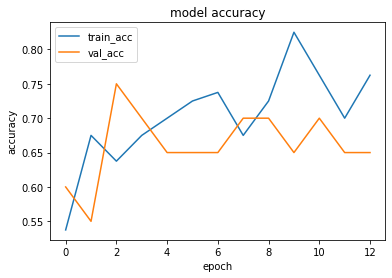

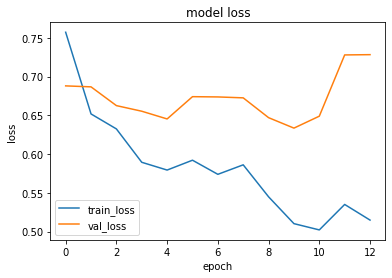

1it [00:00, 15196.75it/s]


prediction for video armflapping_1.mov is [[0.3625877]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.44251728]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.6368467]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.28500026]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.2690577]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.27079028]]
Epoch 1/75
3/3 [==============================] - 1s 200ms/step - loss: 0.8393 - accuracy: 0.3875 - precision: 0.0714 - recall: 0.0270 - val_loss: 0.6996 - val_accuracy: 0.4500 - val_precision: 0.6667 - val_recall: 0.3077
Epoch 2/75
3/3 [==============================] - 0s 168ms/step - loss: 0.6893 - accuracy: 0.5250 - precision: 0.4902 - recall: 0.6757 - val_loss: 0.6211 - val_accuracy: 0.8000 - val_precision: 0.8462 - val_recall: 0.8462
Epoch 3/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6508 - accuracy: 0.7375 - precision: 0.6739 - recall: 0.8378 - val_loss: 0.6620 - val_accuracy: 0.5500 - val_precision: 1.0000 - val_recall: 0.3077
Epoch 4/75
3/3 [==============================] - 0s 178ms/step - loss: 0.6546 - accuracy: 0.6000 - precision: 0.6667 - recall: 0.2703 - val_loss: 0.5968 - val_accuracy: 0.6000 - val_precision: 0.7273 - val_recall: 0.6154
Epoch 5/75
3/3 [==============================] - 0s 132ms/

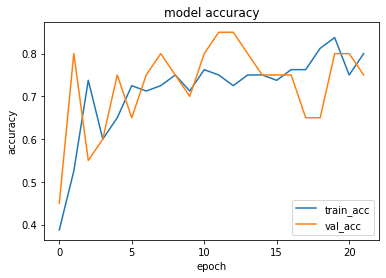

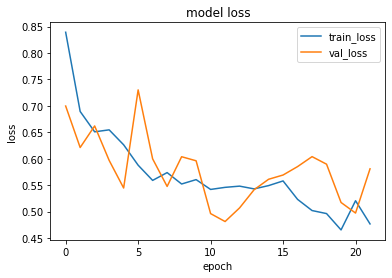

1it [00:00, 13530.01it/s]


prediction for video armflapping_1.mov is [[0.49778363]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_3.mov is [[0.56767666]]


1it [00:00, 12671.61it/s]


prediction for video armflapping_2.mov is [[0.62106764]]


1it [00:00, 14027.77it/s]


prediction for video control_1.mov is [[0.38772887]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.3299862]]


1it [00:00, 14217.98it/s]


prediction for video control_3.mov is [[0.2952538]]
Epoch 1/75
3/3 [==============================] - 1s 198ms/step - loss: 0.6620 - accuracy: 0.6750 - precision: 0.6829 - recall: 0.6829 - val_loss: 0.7027 - val_accuracy: 0.5000 - val_precision: 0.4737 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6595 - accuracy: 0.5625 - precision: 0.5441 - recall: 0.9024 - val_loss: 0.5911 - val_accuracy: 0.8000 - val_precision: 0.8571 - val_recall: 0.6667
Epoch 3/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6188 - accuracy: 0.7125 - precision: 0.7500 - recall: 0.6585 - val_loss: 0.5919 - val_accuracy: 0.7000 - val_precision: 0.6364 - val_recall: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6032 - accuracy: 0.7000 - precision: 0.6889 - recall: 0.7561 - val_loss: 0.5168 - val_accuracy: 0.8000 - val_precision: 0.7778 - val_recall: 0.7778
Epoch 5/75
3/3 [==============================] - 0s 128ms/s

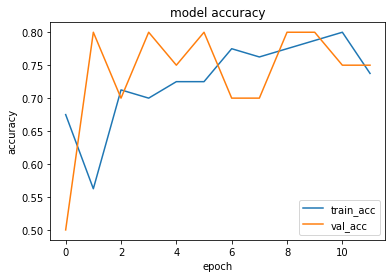

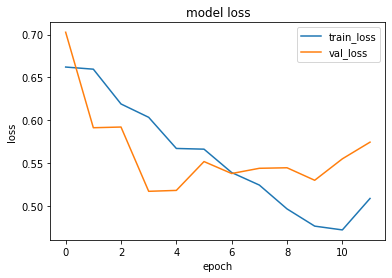

1it [00:00, 17924.38it/s]


prediction for video armflapping_1.mov is [[0.3722521]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_3.mov is [[0.79731333]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.8162681]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.28287634]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.24941]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.2631336]]


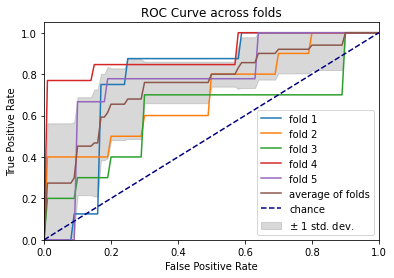

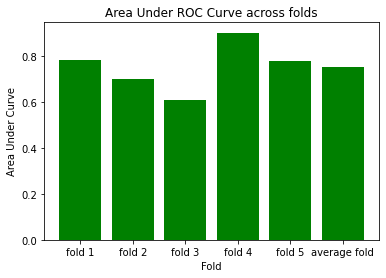

Epoch 1/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6843 - accuracy: 0.5750 - precision: 0.5536 - recall: 0.7750 - val_loss: 0.7239 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6679 - accuracy: 0.6250 - precision: 0.8571 - recall: 0.3000 - val_loss: 0.8194 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 180ms/step - loss: 0.5892 - accuracy: 0.6875 - precision: 0.6364 - recall: 0.8750 - val_loss: 0.7189 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.5463 - accuracy: 0.7500 - precision: 0.7941 - recall: 0.6750 - val_loss: 0.7692 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 173ms/step - loss: 0.5187 - accuracy: 0.7750 - prec

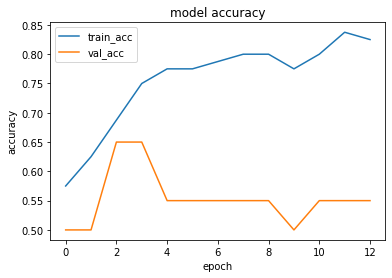

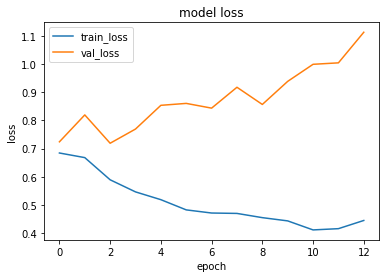

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.42189667]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.4661618]]


1it [00:00, 12483.05it/s]


prediction for video armflapping_2.mov is [[0.5695523]]


1it [00:00, 12228.29it/s]


prediction for video control_1.mov is [[0.33204317]]


1it [00:00, 11781.75it/s]


prediction for video control_2.mov is [[0.30565247]]


1it [00:00, 12372.58it/s]


prediction for video control_3.mov is [[0.28746372]]
Epoch 1/75
3/3 [==============================] - 0s 162ms/step - loss: 0.6515 - accuracy: 0.7125 - precision: 0.6857 - recall: 0.6667 - val_loss: 0.4885 - val_accuracy: 0.8000 - val_precision: 0.9167 - val_recall: 0.7857
Epoch 2/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6491 - accuracy: 0.6125 - precision: 0.5862 - recall: 0.4722 - val_loss: 0.5503 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.7143
Epoch 3/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6146 - accuracy: 0.7375 - precision: 0.7027 - recall: 0.7222 - val_loss: 0.5361 - val_accuracy: 0.7000 - val_precision: 0.9000 - val_recall: 0.6429
Epoch 4/75
3/3 [==============================] - 0s 144ms/step - loss: 0.5951 - accuracy: 0.7375 - precision: 0.7143 - recall: 0.6944 - val_loss: 0.5543 - val_accuracy: 0.7000 - val_precision: 1.0000 - val_recall: 0.5714
Epoch 5/75
3/3 [==============================] - 0s 132ms/

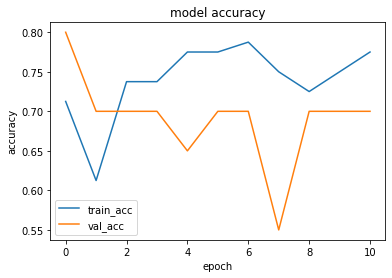

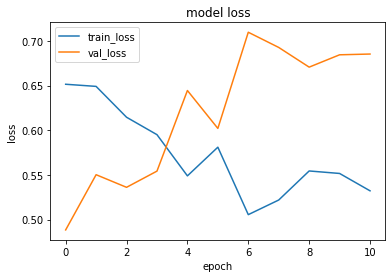

1it [00:00, 13706.88it/s]


prediction for video armflapping_1.mov is [[0.5353178]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.63820124]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.71643114]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.4253982]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.39084136]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.4076395]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7059 - accuracy: 0.4750 - precision: 0.4889 - recall: 0.5366 - val_loss: 0.6342 - val_accuracy: 0.7000 - val_precision: 0.6154 - val_recall: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6367 - accuracy: 0.7000 - precision: 0.6604 - recall: 0.8537 - val_loss: 0.6033 - val_accuracy: 0.7000 - val_precision: 0.6154 - val_recall: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6077 - accuracy: 0.6500 - precision: 0.6327 - recall: 0.7561 - val_loss: 0.4948 - val_accuracy: 0.8500 - val_precision: 1.0000 - val_recall: 0.6667
Epoch 4/75
3/3 [==============================] - 0s 182ms/step - loss: 0.6310 - accuracy: 0.6500 - precision: 0.7600 - recall: 0.4634 - val_loss: 0.5168 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 0.8889
Epoch 5/75
3/3 [==============================] - 0s 130ms/s

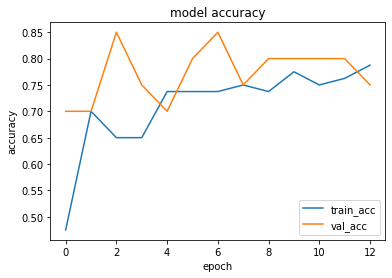

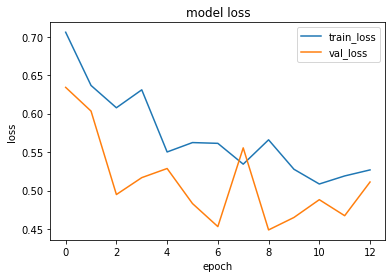

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.3704318]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.38107687]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.44302613]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.33730888]]


1it [00:00, 16384.00it/s]


prediction for video control_2.mov is [[0.32215846]]


1it [00:00, 15768.06it/s]


prediction for video control_3.mov is [[0.31684238]]
Epoch 1/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6808 - accuracy: 0.6000 - precision: 0.6098 - recall: 0.6098 - val_loss: 0.6407 - val_accuracy: 0.7500 - val_precision: 0.8333 - val_recall: 0.5556
Epoch 2/75
3/3 [==============================] - 0s 163ms/step - loss: 0.6777 - accuracy: 0.6125 - precision: 0.7273 - recall: 0.3902 - val_loss: 0.7049 - val_accuracy: 0.6500 - val_precision: 0.5833 - val_recall: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 173ms/step - loss: 0.6037 - accuracy: 0.7125 - precision: 0.6731 - recall: 0.8537 - val_loss: 0.7069 - val_accuracy: 0.6500 - val_precision: 0.5833 - val_recall: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.5678 - accuracy: 0.7250 - precision: 0.7021 - recall: 0.8049 - val_loss: 0.6992 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.6667
Epoch 5/75
3/3 [==============================] - 0s 140ms/

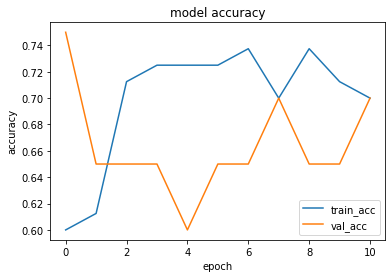

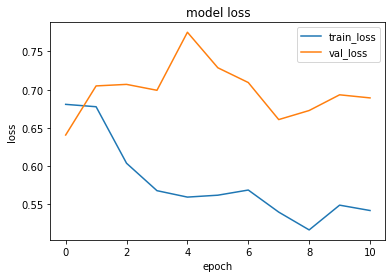

1it [00:00, 18641.35it/s]


prediction for video armflapping_1.mov is [[0.41200656]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.3998262]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_2.mov is [[0.57580817]]


1it [00:00, 15420.24it/s]


prediction for video control_1.mov is [[0.33291674]]


1it [00:00, 16070.13it/s]


prediction for video control_2.mov is [[0.31485316]]


1it [00:00, 14122.24it/s]


prediction for video control_3.mov is [[0.30617493]]
Epoch 1/75
3/3 [==============================] - 1s 153ms/step - loss: 0.7138 - accuracy: 0.4625 - precision: 0.4925 - recall: 0.7857 - val_loss: 0.6862 - val_accuracy: 0.6000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6882 - accuracy: 0.5625 - precision: 0.7692 - recall: 0.2381 - val_loss: 0.6519 - val_accuracy: 0.8000 - val_precision: 0.7000 - val_recall: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6444 - accuracy: 0.6875 - precision: 0.6441 - recall: 0.9048 - val_loss: 0.6186 - val_accuracy: 0.7500 - val_precision: 0.6364 - val_recall: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 173ms/step - loss: 0.6178 - accuracy: 0.6875 - precision: 0.6604 - recall: 0.8333 - val_loss: 0.5358 - val_accuracy: 0.8500 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 5/75
3/3 [==============================] - 0

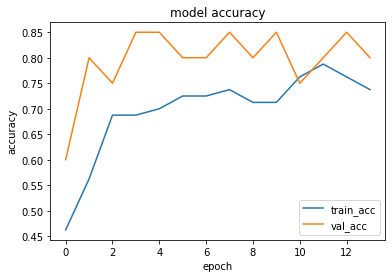

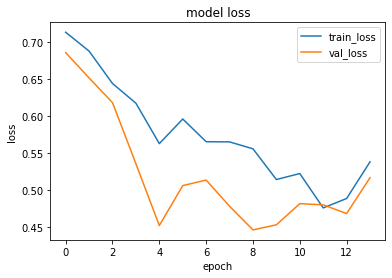

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.36232403]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.7640492]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.7421124]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.32259566]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.22564948]]


1it [00:00, 17848.10it/s]

prediction for video control_3.mov is [[0.29122806]]


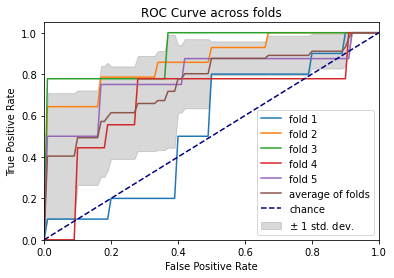

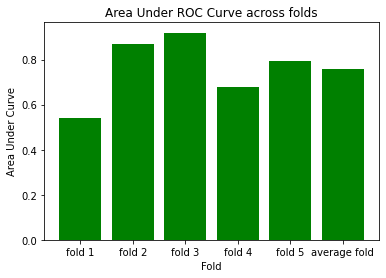

Epoch 1/75
3/3 [==============================] - 0s 134ms/step - loss: 0.7397 - accuracy: 0.5375 - precision: 0.5088 - recall: 0.7632 - val_loss: 0.7018 - val_accuracy: 0.4000 - val_precision: 0.5000 - val_recall: 0.0833
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6607 - accuracy: 0.6500 - precision: 0.9167 - recall: 0.2895 - val_loss: 0.5484 - val_accuracy: 0.8000 - val_precision: 0.8333 - val_recall: 0.8333
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6428 - accuracy: 0.6375 - precision: 0.5789 - recall: 0.8684 - val_loss: 0.6143 - val_accuracy: 0.7000 - val_precision: 0.8750 - val_recall: 0.5833
Epoch 4/75
3/3 [==============================] - 0s 118ms/step - loss: 0.6133 - accuracy: 0.6500 - precision: 0.8571 - recall: 0.3158 - val_loss: 0.6154 - val_accuracy: 0.6500 - val_precision: 0.8571 - val_recall: 0.5000
Epoch 5/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5952 - accuracy: 0.7125 - precision: 0

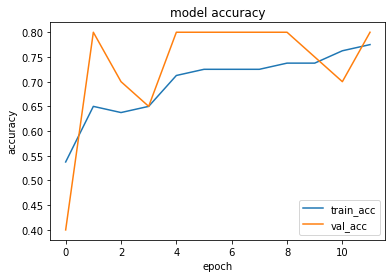

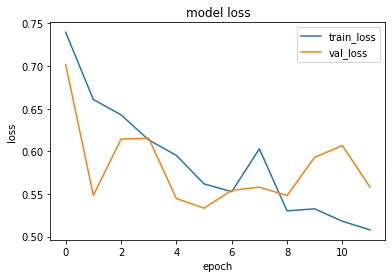

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.53834337]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.56764346]]


1it [00:00, 16194.22it/s]


prediction for video armflapping_2.mov is [[0.6078417]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.481017]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.45786712]]


1it [00:00, 12671.61it/s]


prediction for video control_3.mov is [[0.45007333]]
Epoch 1/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6867 - accuracy: 0.4500 - precision: 0.3571 - recall: 0.2778 - val_loss: 0.6267 - val_accuracy: 0.6500 - val_precision: 0.7333 - val_recall: 0.7857
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6376 - accuracy: 0.6875 - precision: 0.6038 - recall: 0.8889 - val_loss: 0.6404 - val_accuracy: 0.7500 - val_precision: 0.9091 - val_recall: 0.7143
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.5939 - accuracy: 0.6875 - precision: 0.7037 - recall: 0.5278 - val_loss: 0.6458 - val_accuracy: 0.6500 - val_precision: 0.7692 - val_recall: 0.7143
Epoch 4/75
3/3 [==============================] - 0s 145ms/step - loss: 0.5623 - accuracy: 0.7125 - precision: 0.6383 - recall: 0.8333 - val_loss: 0.6529 - val_accuracy: 0.6500 - val_precision: 0.7692 - val_recall: 0.7143
Epoch 5/75
3/3 [==============================] - 0s 147ms/

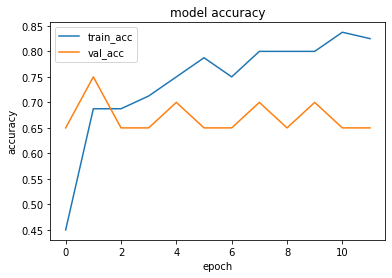

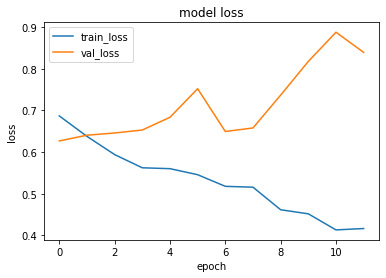

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.6031297]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.7523718]]


1it [00:00, 13189.64it/s]


prediction for video armflapping_2.mov is [[0.7569014]]


1it [00:00, 12787.51it/s]


prediction for video control_1.mov is [[0.17040351]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.11493325]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.11205772]]
Epoch 1/75
3/3 [==============================] - 1s 191ms/step - loss: 0.6962 - accuracy: 0.5750 - precision: 0.5962 - recall: 0.7045 - val_loss: 0.6238 - val_accuracy: 0.5500 - val_precision: 0.4000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 179ms/step - loss: 0.6385 - accuracy: 0.6125 - precision: 0.6327 - recall: 0.7045 - val_loss: 0.6058 - val_accuracy: 0.8000 - val_precision: 0.6250 - val_recall: 0.8333
Epoch 3/75
3/3 [==============================] - 0s 170ms/step - loss: 0.6358 - accuracy: 0.6625 - precision: 0.6604 - recall: 0.7955 - val_loss: 0.6140 - val_accuracy: 0.7500 - val_precision: 0.5556 - val_recall: 0.8333
Epoch 4/75
3/3 [==============================] - 0s 171ms/step - loss: 0.5922 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.8182 - val_loss: 0.5541 - val_accuracy: 0.7500 - val_precision: 0.5556 - val_recall: 0.8333
Epoch 5/75
3/3 [==============================] - 0s 145ms/

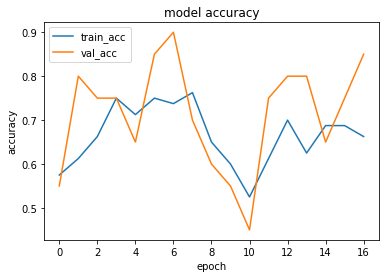

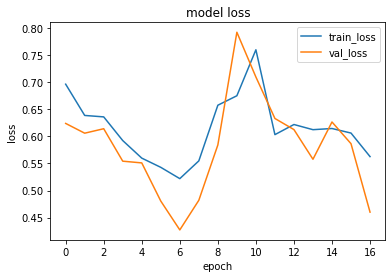

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.5351775]]


1it [00:00, 8848.74it/s]


prediction for video armflapping_3.mov is [[0.59148777]]


1it [00:00, 12633.45it/s]


prediction for video armflapping_2.mov is [[0.61620456]]


1it [00:00, 13148.29it/s]


prediction for video control_1.mov is [[0.38319713]]


1it [00:00, 12787.51it/s]


prediction for video control_2.mov is [[0.3108456]]


1it [00:00, 13706.88it/s]


prediction for video control_3.mov is [[0.25012195]]
Epoch 1/75
3/3 [==============================] - 0s 146ms/step - loss: 0.7098 - accuracy: 0.4875 - precision: 0.5088 - recall: 0.6905 - val_loss: 0.7120 - val_accuracy: 0.4500 - val_precision: 0.4118 - val_recall: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6154 - accuracy: 0.6375 - precision: 0.5970 - recall: 0.9524 - val_loss: 0.6569 - val_accuracy: 0.7000 - val_precision: 0.6000 - val_recall: 0.7500
Epoch 3/75
3/3 [==============================] - 0s 138ms/step - loss: 0.5885 - accuracy: 0.7375 - precision: 0.7442 - recall: 0.7619 - val_loss: 0.7730 - val_accuracy: 0.5000 - val_precision: 0.3750 - val_recall: 0.3750
Epoch 4/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6191 - accuracy: 0.7250 - precision: 0.7632 - recall: 0.6905 - val_loss: 0.7014 - val_accuracy: 0.5000 - val_precision: 0.3750 - val_recall: 0.3750
Epoch 5/75
3/3 [==============================] - 0s 149ms/

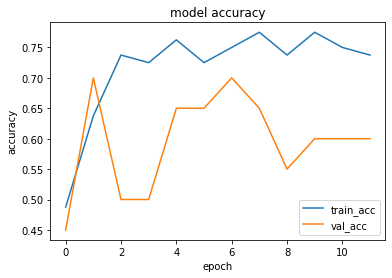

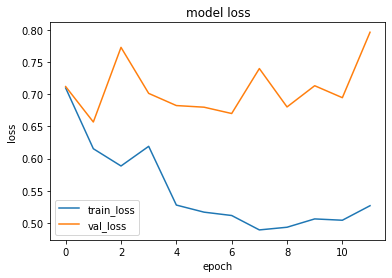

1it [00:00, 12787.51it/s]


prediction for video armflapping_1.mov is [[0.7819654]]


1it [00:00, 11275.01it/s]


prediction for video armflapping_3.mov is [[0.90912634]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.38242486]]


1it [00:00, 9258.95it/s]


prediction for video control_1.mov is [[0.37010542]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.27911317]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.21319276]]
Epoch 1/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6892 - accuracy: 0.5375 - precision: 0.5405 - recall: 0.5000 - val_loss: 0.6815 - val_accuracy: 0.5500 - val_precision: 0.6667 - val_recall: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6485 - accuracy: 0.5750 - precision: 0.5714 - recall: 0.6000 - val_loss: 0.6154 - val_accuracy: 0.8000 - val_precision: 0.7500 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6105 - accuracy: 0.7125 - precision: 0.7576 - recall: 0.6250 - val_loss: 0.6480 - val_accuracy: 0.5500 - val_precision: 0.6667 - val_recall: 0.2000
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6100 - accuracy: 0.7250 - precision: 0.8214 - recall: 0.5750 - val_loss: 0.6019 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 134ms/

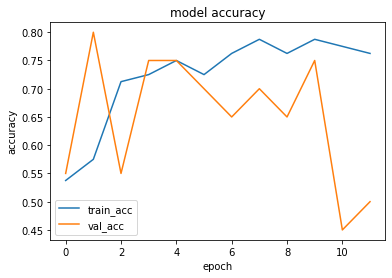

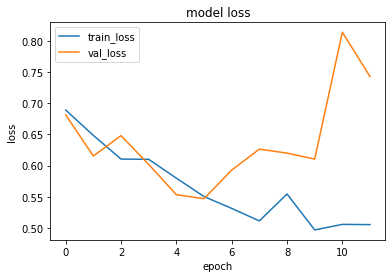

1it [00:00, 13842.59it/s]


prediction for video armflapping_1.mov is [[0.4547909]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_3.mov is [[0.39215532]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.48618197]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.25159454]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.32744914]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.20610544]]


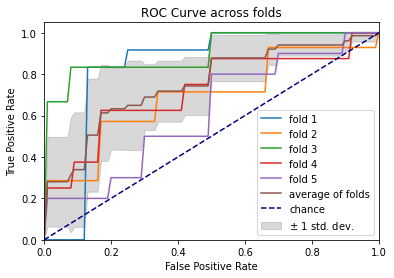

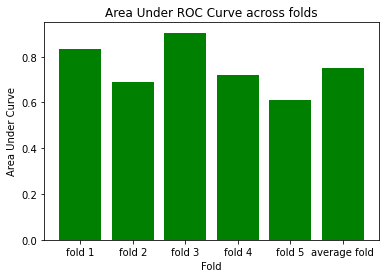

Epoch 1/75
3/3 [==============================] - 0s 177ms/step - loss: 0.6705 - accuracy: 0.5750 - precision: 0.5918 - recall: 0.6744 - val_loss: 0.9338 - val_accuracy: 0.3500 - val_precision: 0.3500 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6072 - accuracy: 0.6500 - precision: 0.6190 - recall: 0.9070 - val_loss: 0.7241 - val_accuracy: 0.6500 - val_precision: 0.5000 - val_recall: 0.2857
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6487 - accuracy: 0.6875 - precision: 0.7647 - recall: 0.6047 - val_loss: 0.7938 - val_accuracy: 0.7000 - val_precision: 0.5556 - val_recall: 0.7143
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.5591 - accuracy: 0.7375 - precision: 0.7391 - recall: 0.7907 - val_loss: 0.7709 - val_accuracy: 0.7000 - val_precision: 0.5556 - val_recall: 0.7143
Epoch 5/75
3/3 [==============================] - 0s 134ms/step - loss: 0.5241 - accuracy: 0.7625 - precision: 0

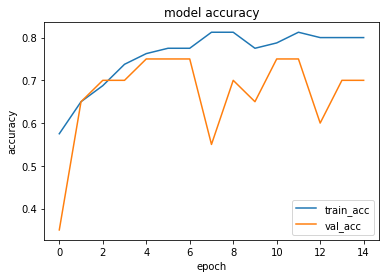

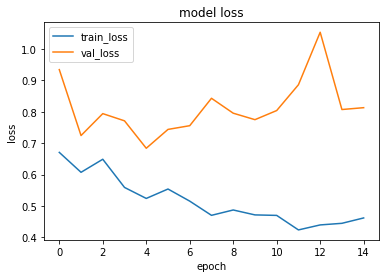

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.44405502]]


1it [00:00, 13842.59it/s]


prediction for video armflapping_3.mov is [[0.50112414]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.5358028]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.2874491]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.24657845]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.19357887]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7190 - accuracy: 0.5750 - precision: 0.5946 - recall: 0.5366 - val_loss: 0.6532 - val_accuracy: 0.5000 - val_precision: 0.4706 - val_recall: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6776 - accuracy: 0.6000 - precision: 0.5789 - recall: 0.8049 - val_loss: 0.6582 - val_accuracy: 0.6500 - val_precision: 0.7500 - val_recall: 0.3333
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6455 - accuracy: 0.6875 - precision: 0.7353 - recall: 0.6098 - val_loss: 0.6451 - val_accuracy: 0.7000 - val_precision: 0.8000 - val_recall: 0.4444
Epoch 4/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6327 - accuracy: 0.7375 - precision: 0.7778 - recall: 0.6829 - val_loss: 0.6234 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.6667
Epoch 5/75
3/3 [==============================] - 0s 128ms/

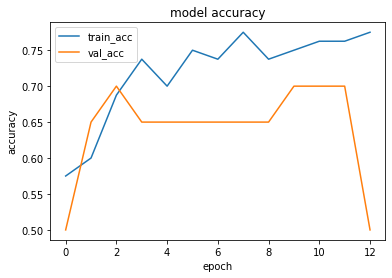

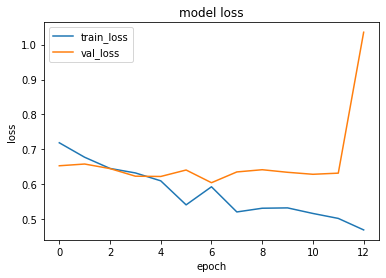

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.8856131]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.9473741]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_2.mov is [[0.89298236]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.21702963]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.17933598]]


1it [00:00, 16320.25it/s]


prediction for video control_3.mov is [[0.20298582]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.7711 - accuracy: 0.3375 - precision: 0.3934 - recall: 0.6000 - val_loss: 0.6842 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6740 - accuracy: 0.6625 - precision: 0.6857 - recall: 0.6000 - val_loss: 0.6678 - val_accuracy: 0.6000 - val_precision: 0.6667 - val_recall: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6724 - accuracy: 0.6875 - precision: 0.8000 - recall: 0.5000 - val_loss: 0.6448 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6416 - accuracy: 0.6750 - precision: 0.6667 - recall: 0.7000 - val_loss: 0.5856 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 118ms/

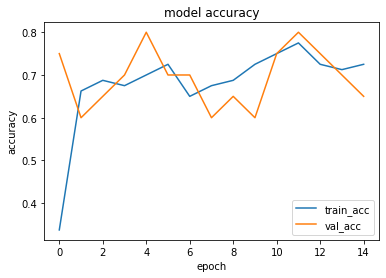

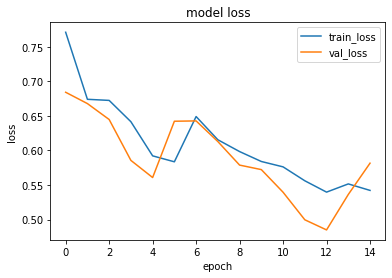

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.42145133]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_3.mov is [[0.4994579]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.57779694]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.34940118]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.32406658]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.3285898]]
Epoch 1/75
3/3 [==============================] - 0s 187ms/step - loss: 0.7155 - accuracy: 0.4875 - precision: 0.4909 - recall: 0.6750 - val_loss: 0.6602 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6393 - accuracy: 0.7125 - precision: 0.7297 - recall: 0.6750 - val_loss: 0.6058 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6657 - accuracy: 0.6375 - precision: 0.5932 - recall: 0.8750 - val_loss: 0.5858 - val_accuracy: 0.8500 - val_precision: 0.8889 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.5921 - accuracy: 0.7125 - precision: 0.7742 - recall: 0.6000 - val_loss: 0.6172 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 5/75
3/3 [==============================] - 0s 126ms/s

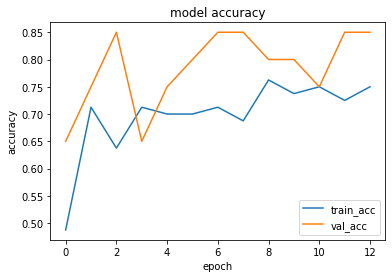

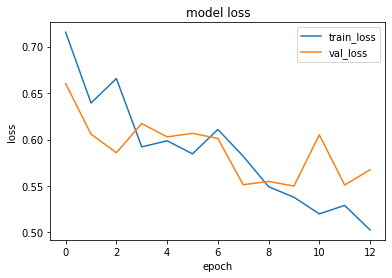

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.5153499]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.56163037]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.5988072]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.47096178]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.45526814]]


1it [00:00, 12372.58it/s]


prediction for video control_3.mov is [[0.44521534]]
Epoch 1/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6842 - accuracy: 0.5375 - precision: 0.4872 - recall: 0.5278 - val_loss: 0.8506 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 139ms/step - loss: 0.7154 - accuracy: 0.5625 - precision: 1.0000 - recall: 0.0278 - val_loss: 0.6154 - val_accuracy: 0.7500 - val_precision: 0.8462 - val_recall: 0.7857
Epoch 3/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6500 - accuracy: 0.6750 - precision: 0.6190 - recall: 0.7222 - val_loss: 0.5535 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.8571
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6015 - accuracy: 0.7250 - precision: 0.6591 - recall: 0.8056 - val_loss: 0.6497 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.8571
Epoch 5/75
3/3 [==============================] - 0

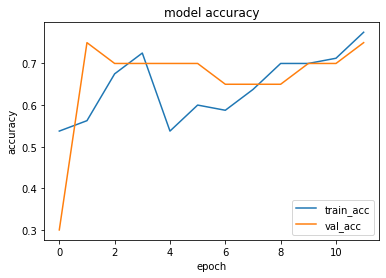

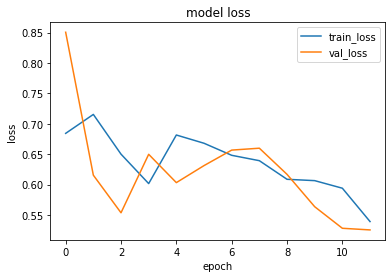

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.46691003]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.6808739]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_2.mov is [[0.6608361]]


1it [00:00, 15827.56it/s]


prediction for video control_1.mov is [[0.30697232]]


1it [00:00, 11915.64it/s]


prediction for video control_2.mov is [[0.26759124]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.2538852]]


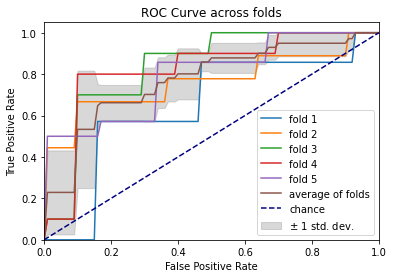

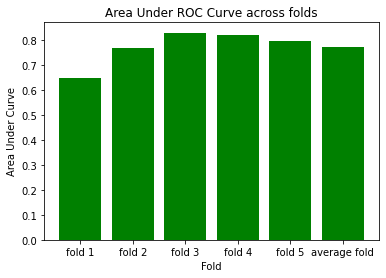

Epoch 1/75
3/3 [==============================] - 0s 152ms/step - loss: 0.7005 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5750 - val_loss: 0.6879 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6331 - accuracy: 0.5875 - precision: 0.5493 - recall: 0.9750 - val_loss: 0.7625 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6204 - accuracy: 0.7250 - precision: 0.7500 - recall: 0.6750 - val_loss: 0.7022 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6013 - accuracy: 0.6875 - precision: 0.6271 - recall: 0.9250 - val_loss: 0.6018 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 136ms/step - loss: 0.5906 - accuracy: 0.7125 - precision: 0

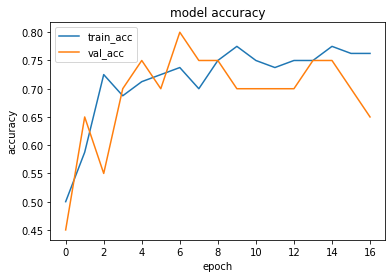

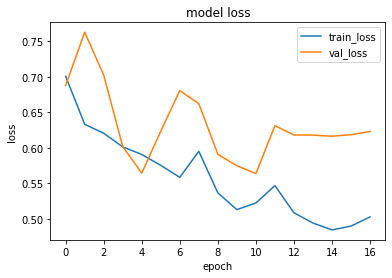

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.3434472]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_3.mov is [[0.32660657]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.5386193]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.3468057]]


1it [00:00, 13530.01it/s]


prediction for video control_2.mov is [[0.34728014]]


1it [00:00, 14665.40it/s]


prediction for video control_3.mov is [[0.3463235]]
Epoch 1/75
3/3 [==============================] - 0s 148ms/step - loss: 0.7058 - accuracy: 0.5375 - precision: 0.5789 - recall: 0.2750 - val_loss: 0.6734 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6454 - accuracy: 0.5750 - precision: 0.5417 - recall: 0.9750 - val_loss: 0.6367 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6214 - accuracy: 0.7125 - precision: 0.7576 - recall: 0.6250 - val_loss: 0.5640 - val_accuracy: 0.8000 - val_precision: 0.7500 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.5988 - accuracy: 0.6875 - precision: 0.6531 - recall: 0.8000 - val_loss: 0.5650 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 144ms/s

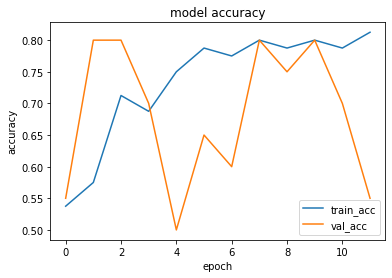

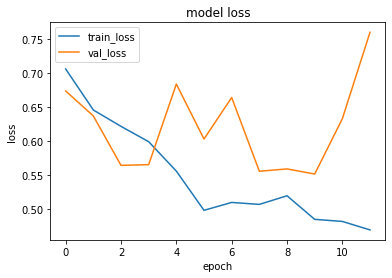

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.3672323]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.45138136]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.56360656]]


1it [00:00, 14873.42it/s]


prediction for video control_1.mov is [[0.24553788]]


1it [00:00, 13315.25it/s]


prediction for video control_2.mov is [[0.21397507]]


1it [00:00, 14768.68it/s]


prediction for video control_3.mov is [[0.21161798]]
Epoch 1/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6509 - accuracy: 0.5875 - precision: 0.5472 - recall: 0.7632 - val_loss: 0.9356 - val_accuracy: 0.4000 - val_precision: 0.5000 - val_recall: 0.0833
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.7099 - accuracy: 0.6375 - precision: 0.6364 - recall: 0.5526 - val_loss: 0.7480 - val_accuracy: 0.7000 - val_precision: 0.6875 - val_recall: 0.9167
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6323 - accuracy: 0.7125 - precision: 0.6829 - recall: 0.7368 - val_loss: 0.6963 - val_accuracy: 0.6000 - val_precision: 0.6429 - val_recall: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6147 - accuracy: 0.7375 - precision: 0.7576 - recall: 0.6579 - val_loss: 0.6880 - val_accuracy: 0.6000 - val_precision: 0.6429 - val_recall: 0.7500
Epoch 5/75
3/3 [==============================] - 0s 125ms/

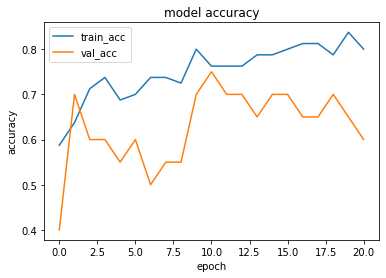

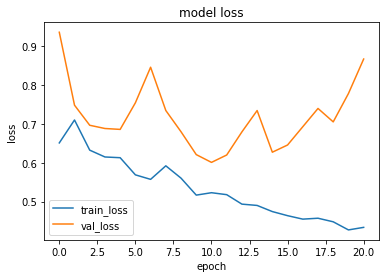

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.19898799]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_3.mov is [[0.8433354]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.733881]]


1it [00:00, 14027.77it/s]


prediction for video control_1.mov is [[0.18246317]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.1788831]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.17904866]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6888 - accuracy: 0.5750 - precision: 0.5763 - recall: 0.7907 - val_loss: 0.6859 - val_accuracy: 0.5000 - val_precision: 0.4118 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6760 - accuracy: 0.5625 - precision: 0.5513 - recall: 1.0000 - val_loss: 0.6345 - val_accuracy: 0.7500 - val_precision: 0.5833 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6222 - accuracy: 0.7250 - precision: 0.7333 - recall: 0.7674 - val_loss: 0.6235 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 0.5714
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6107 - accuracy: 0.6875 - precision: 0.8750 - recall: 0.4884 - val_loss: 0.5958 - val_accuracy: 0.8000 - val_precision: 0.7143 - val_recall: 0.7143
Epoch 5/75
3/3 [==============================] - 0s 124ms/

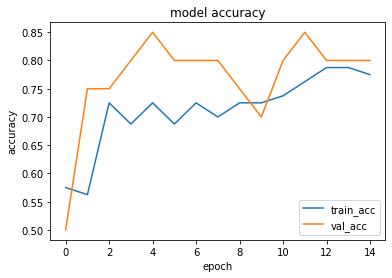

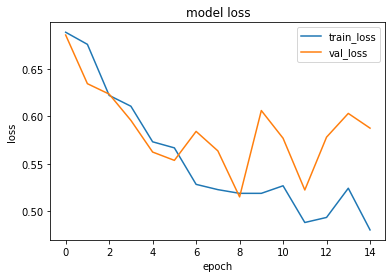

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.5110066]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_3.mov is [[0.6339136]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_2.mov is [[0.6359755]]


1it [00:00, 16070.13it/s]


prediction for video control_1.mov is [[0.4346312]]


1it [00:00, 13662.23it/s]


prediction for video control_2.mov is [[0.39335403]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.37758744]]
Epoch 1/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6890 - accuracy: 0.4875 - precision: 0.4844 - recall: 0.7949 - val_loss: 0.6251 - val_accuracy: 0.6000 - val_precision: 0.7143 - val_recall: 0.4545
Epoch 2/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6246 - accuracy: 0.7375 - precision: 0.7045 - recall: 0.7949 - val_loss: 0.5980 - val_accuracy: 0.6500 - val_precision: 0.7500 - val_recall: 0.5455
Epoch 3/75
3/3 [==============================] - 0s 138ms/step - loss: 0.5862 - accuracy: 0.7250 - precision: 0.6889 - recall: 0.7949 - val_loss: 0.7055 - val_accuracy: 0.6500 - val_precision: 0.8333 - val_recall: 0.4545
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.5384 - accuracy: 0.7250 - precision: 0.7576 - recall: 0.6410 - val_loss: 0.7800 - val_accuracy: 0.6500 - val_precision: 0.7500 - val_recall: 0.5455
Epoch 5/75
3/3 [==============================] - 0s 125ms/

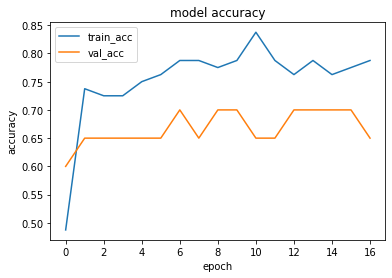

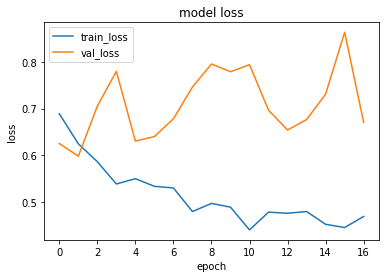

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.44368196]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_3.mov is [[0.7315731]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.76901895]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.3039589]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.23650193]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.25195676]]


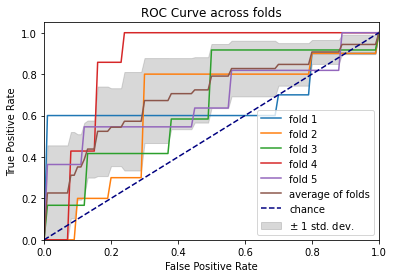

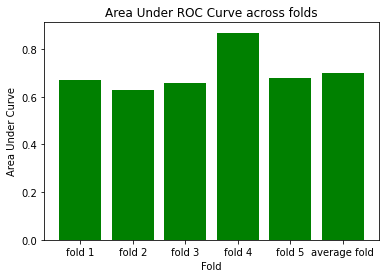

Epoch 1/75
3/3 [==============================] - 0s 187ms/step - loss: 0.6610 - accuracy: 0.6875 - precision: 0.6600 - recall: 0.8049 - val_loss: 0.7094 - val_accuracy: 0.5000 - val_precision: 0.4706 - val_recall: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6584 - accuracy: 0.6625 - precision: 0.6522 - recall: 0.7317 - val_loss: 0.6442 - val_accuracy: 0.7000 - val_precision: 0.8000 - val_recall: 0.4444
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5921 - accuracy: 0.7000 - precision: 0.7297 - recall: 0.6585 - val_loss: 0.6465 - val_accuracy: 0.7000 - val_precision: 0.8000 - val_recall: 0.4444
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5548 - accuracy: 0.7375 - precision: 0.7174 - recall: 0.8049 - val_loss: 0.6903 - val_accuracy: 0.7000 - val_precision: 0.7143 - val_recall: 0.5556
Epoch 5/75
3/3 [==============================] - 0s 126ms/step - loss: 0.5552 - accuracy: 0.7250 - precision: 0

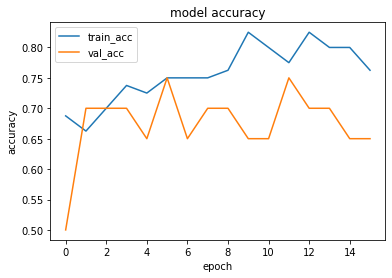

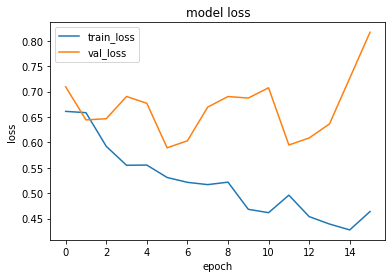

1it [00:00, 14217.98it/s]


prediction for video armflapping_1.mov is [[0.55996346]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.6292093]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_2.mov is [[0.67224675]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.4554726]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.3976379]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.3689012]]
Epoch 1/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6940 - accuracy: 0.5125 - precision: 0.5179 - recall: 0.7073 - val_loss: 0.6384 - val_accuracy: 0.5500 - val_precision: 0.5000 - val_recall: 0.6667
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6282 - accuracy: 0.6375 - precision: 0.5938 - recall: 0.9268 - val_loss: 0.6137 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6051 - accuracy: 0.7125 - precision: 0.6875 - recall: 0.8049 - val_loss: 0.6479 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.5830 - accuracy: 0.7375 - precision: 0.7778 - recall: 0.6829 - val_loss: 0.6555 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 0.8889
Epoch 5/75
3/3 [==============================] - 0s 126ms/s

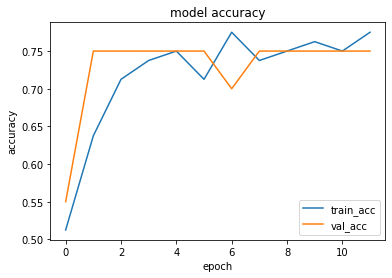

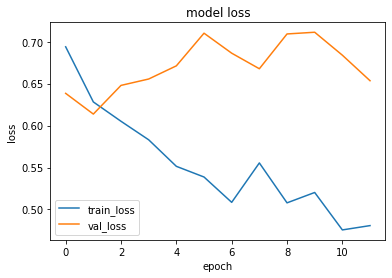

1it [00:00, 15196.75it/s]


prediction for video armflapping_1.mov is [[0.44955724]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.45717657]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.63714784]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.28971332]]


1it [00:00, 15827.56it/s]


prediction for video control_2.mov is [[0.25702482]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.2451252]]
Epoch 1/75
3/3 [==============================] - 0s 128ms/step - loss: 0.7373 - accuracy: 0.5500 - precision: 0.5000 - recall: 0.5278 - val_loss: 0.7249 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6681 - accuracy: 0.6000 - precision: 0.7000 - recall: 0.1944 - val_loss: 0.7221 - val_accuracy: 0.3500 - val_precision: 1.0000 - val_recall: 0.0714
Epoch 3/75
3/3 [==============================] - 0s 118ms/step - loss: 0.6562 - accuracy: 0.6750 - precision: 0.9167 - recall: 0.3056 - val_loss: 0.7006 - val_accuracy: 0.4000 - val_precision: 0.7500 - val_recall: 0.2143
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6036 - accuracy: 0.7125 - precision: 0.7826 - recall: 0.5000 - val_loss: 0.7724 - val_accuracy: 0.6500 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 5/75
3/3 [==============================] - 0s

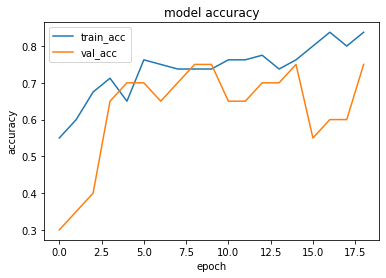

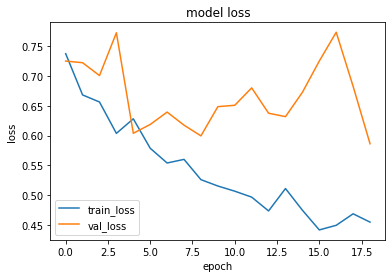

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.54211295]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.686287]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.7048992]]


1it [00:00, 16070.13it/s]


prediction for video control_1.mov is [[0.49111643]]


1it [00:00, 15827.56it/s]


prediction for video control_2.mov is [[0.3860777]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.37118644]]
Epoch 1/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6833 - accuracy: 0.4750 - precision: 0.4800 - recall: 0.6000 - val_loss: 0.5722 - val_accuracy: 0.7000 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 118ms/step - loss: 0.6807 - accuracy: 0.6000 - precision: 0.5588 - recall: 0.9500 - val_loss: 0.7125 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 118ms/step - loss: 0.6421 - accuracy: 0.7000 - precision: 0.6538 - recall: 0.8500 - val_loss: 0.6538 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6458 - accuracy: 0.6625 - precision: 0.7600 - recall: 0.4750 - val_loss: 0.6076 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 126ms/

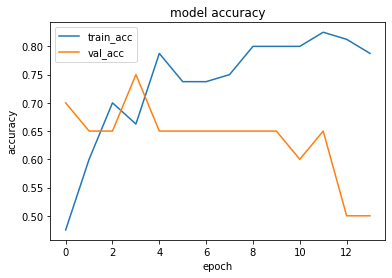

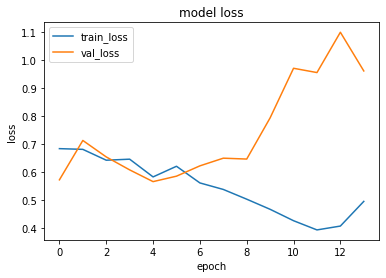

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.8169722]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.92706203]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.8565031]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.6594187]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.28982353]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.27765864]]
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6578 - accuracy: 0.5000 - precision: 0.5192 - recall: 0.6429 - val_loss: 1.1217 - val_accuracy: 0.4500 - val_precision: 0.4211 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.7576 - accuracy: 0.6375 - precision: 0.6102 - recall: 0.8571 - val_loss: 0.6198 - val_accuracy: 0.9000 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6087 - accuracy: 0.6750 - precision: 0.7500 - recall: 0.5714 - val_loss: 0.6177 - val_accuracy: 0.8500 - val_precision: 0.7778 - val_recall: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5825 - accuracy: 0.7125 - precision: 0.7209 - recall: 0.7381 - val_loss: 0.6655 - val_accuracy: 0.7000 - val_precision: 0.5833 - val_recall: 0.8750
Epoch 5/75
3/3 [==============================] - 0s 123ms/

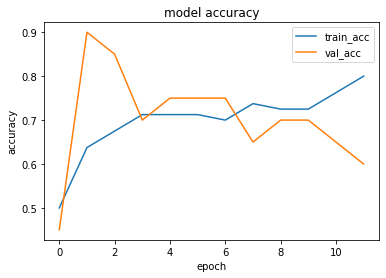

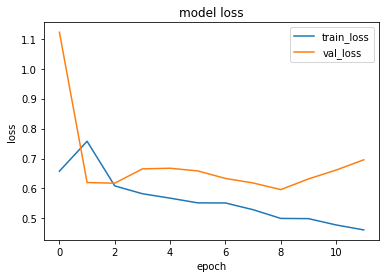

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.48824847]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.4716288]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.51596576]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.465812]]


1it [00:00, 16384.00it/s]


prediction for video control_2.mov is [[0.45378056]]


1it [00:00, 16194.22it/s]

prediction for video control_3.mov is [[0.452646]]


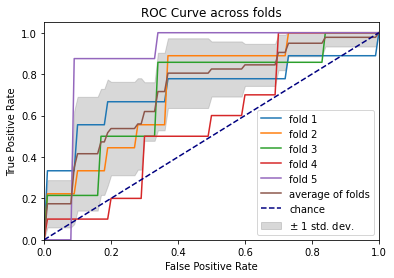

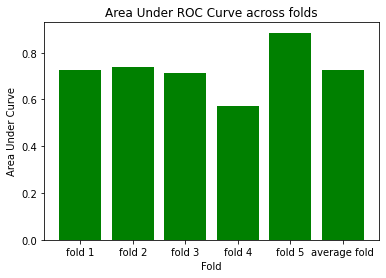

Epoch 1/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6883 - accuracy: 0.4750 - precision: 0.4500 - recall: 0.4737 - val_loss: 0.6204 - val_accuracy: 0.6000 - val_precision: 0.6111 - val_recall: 0.9167
Epoch 2/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6320 - accuracy: 0.6000 - precision: 0.5441 - recall: 0.9737 - val_loss: 0.6426 - val_accuracy: 0.7000 - val_precision: 0.8000 - val_recall: 0.6667
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5907 - accuracy: 0.7250 - precision: 0.6905 - recall: 0.7632 - val_loss: 0.6268 - val_accuracy: 0.7500 - val_precision: 0.8182 - val_recall: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5837 - accuracy: 0.7375 - precision: 0.6977 - recall: 0.7895 - val_loss: 0.6624 - val_accuracy: 0.7500 - val_precision: 0.8889 - val_recall: 0.6667
Epoch 5/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5454 - accuracy: 0.7125 - precision: 0

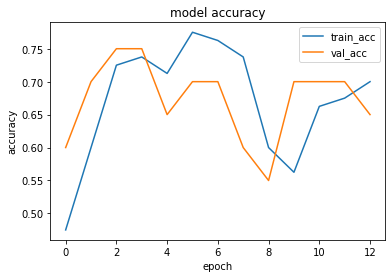

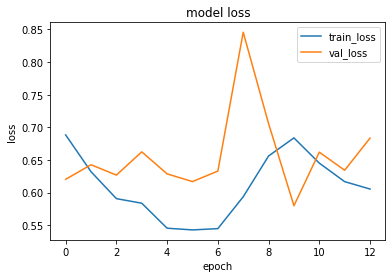

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.49477658]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.58285093]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.65228724]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.27087015]]


1it [00:00, 16320.25it/s]


prediction for video control_2.mov is [[0.21175197]]


1it [00:00, 17623.13it/s]


prediction for video control_3.mov is [[0.26172078]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.7006 - accuracy: 0.5250 - precision: 0.5676 - recall: 0.4884 - val_loss: 0.7975 - val_accuracy: 0.4000 - val_precision: 0.3684 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6370 - accuracy: 0.6125 - precision: 0.6154 - recall: 0.7442 - val_loss: 0.7424 - val_accuracy: 0.6500 - val_precision: 0.5000 - val_recall: 0.7143
Epoch 3/75
3/3 [==============================] - 0s 129ms/step - loss: 0.5952 - accuracy: 0.7625 - precision: 0.7727 - recall: 0.7907 - val_loss: 0.7126 - val_accuracy: 0.6500 - val_precision: 0.5000 - val_recall: 0.7143
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5735 - accuracy: 0.7375 - precision: 0.7292 - recall: 0.8140 - val_loss: 0.5764 - val_accuracy: 0.7000 - val_precision: 0.5714 - val_recall: 0.5714
Epoch 5/75
3/3 [==============================] - 0s 132ms/

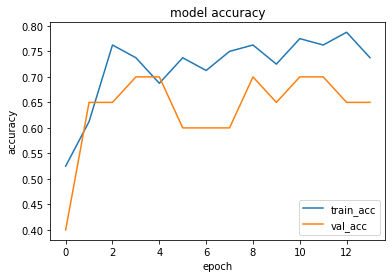

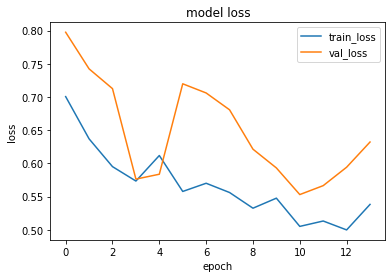

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.52301455]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.30580845]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.5920478]]


1it [00:00, 16070.13it/s]


prediction for video control_1.mov is [[0.38532907]]


1it [00:00, 16448.25it/s]


prediction for video control_2.mov is [[0.2913498]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.32068506]]
Epoch 1/75
3/3 [==============================] - 0s 126ms/step - loss: 0.7188 - accuracy: 0.4125 - precision: 0.3636 - recall: 0.4571 - val_loss: 0.6349 - val_accuracy: 0.8500 - val_precision: 0.9286 - val_recall: 0.8667
Epoch 2/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6829 - accuracy: 0.6250 - precision: 0.5532 - recall: 0.7429 - val_loss: 0.6073 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.6667
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6339 - accuracy: 0.6625 - precision: 0.6538 - recall: 0.4857 - val_loss: 0.6379 - val_accuracy: 0.7500 - val_precision: 0.9167 - val_recall: 0.7333
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6744 - accuracy: 0.6250 - precision: 0.5532 - recall: 0.7429 - val_loss: 0.5223 - val_accuracy: 0.8500 - val_precision: 0.9286 - val_recall: 0.8667
Epoch 5/75
3/3 [==============================] - 0s 120ms/

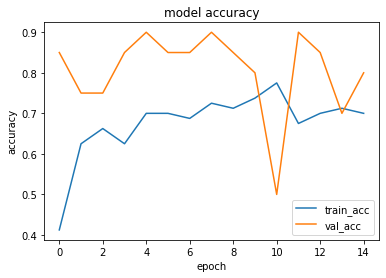

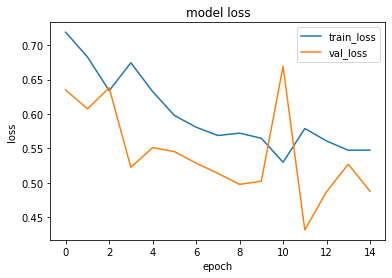

1it [00:00, 16384.00it/s]


prediction for video armflapping_1.mov is [[0.50972205]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_3.mov is [[0.52378726]]


1it [00:00, 13934.56it/s]


prediction for video armflapping_2.mov is [[0.5695813]]


1it [00:00, 16912.52it/s]


prediction for video control_1.mov is [[0.45979983]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.43099552]]


1it [00:00, 16980.99it/s]


prediction for video control_3.mov is [[0.40191734]]
Epoch 1/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6713 - accuracy: 0.5125 - precision: 0.5417 - recall: 0.6047 - val_loss: 1.2961 - val_accuracy: 0.3500 - val_precision: 0.3500 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.7181 - accuracy: 0.6750 - precision: 0.6308 - recall: 0.9535 - val_loss: 0.7352 - val_accuracy: 0.5500 - val_precision: 0.4167 - val_recall: 0.7143
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6489 - accuracy: 0.6750 - precision: 0.7073 - recall: 0.6744 - val_loss: 0.6457 - val_accuracy: 0.6000 - val_precision: 0.4444 - val_recall: 0.5714
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6203 - accuracy: 0.7000 - precision: 0.7714 - recall: 0.6279 - val_loss: 0.6430 - val_accuracy: 0.6500 - val_precision: 0.5000 - val_recall: 0.7143
Epoch 5/75
3/3 [==============================] - 0s 127ms/

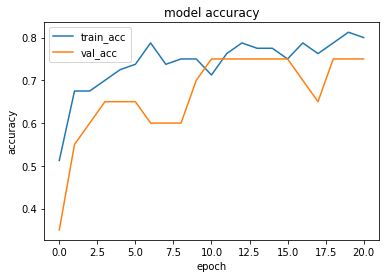

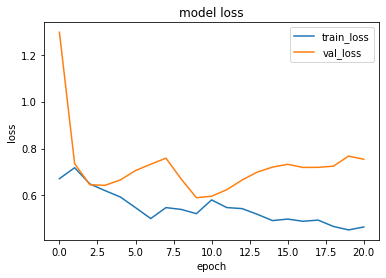

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.706192]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.71037775]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.8458259]]


1it [00:00, 13189.64it/s]


prediction for video control_1.mov is [[0.261024]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.23865762]]


1it [00:00, 14027.77it/s]


prediction for video control_3.mov is [[0.22432661]]
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6759 - accuracy: 0.4750 - precision: 0.4894 - recall: 0.5610 - val_loss: 0.7256 - val_accuracy: 0.5000 - val_precision: 0.4706 - val_recall: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6681 - accuracy: 0.5625 - precision: 0.5536 - recall: 0.7561 - val_loss: 0.6759 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6071 - accuracy: 0.7000 - precision: 0.7576 - recall: 0.6098 - val_loss: 0.6557 - val_accuracy: 0.7000 - val_precision: 0.7143 - val_recall: 0.5556
Epoch 4/75
3/3 [==============================] - 0s 120ms/step - loss: 0.5901 - accuracy: 0.7250 - precision: 0.8065 - recall: 0.6098 - val_loss: 0.6394 - val_accuracy: 0.7000 - val_precision: 0.7143 - val_recall: 0.5556
Epoch 5/75
3/3 [==============================] - 0s 118ms/

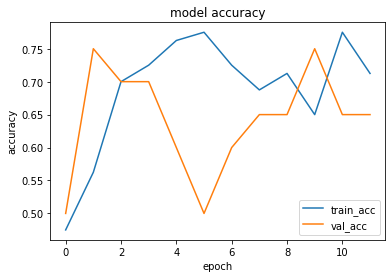

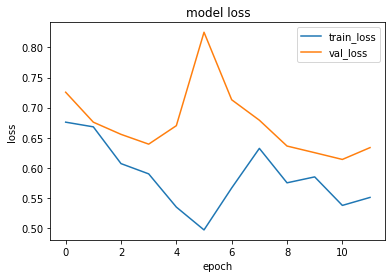

1it [00:00, 15196.75it/s]


prediction for video armflapping_1.mov is [[0.39533642]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.6335155]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.5132632]]


1it [00:00, 15196.75it/s]


prediction for video control_1.mov is [[0.35681707]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.33928388]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.3407281]]


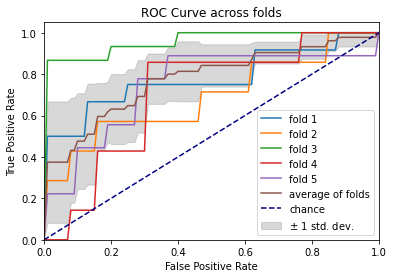

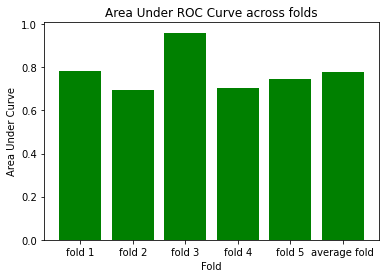

Epoch 1/75
3/3 [==============================] - 1s 206ms/step - loss: 0.7605 - accuracy: 0.5125 - precision: 0.4000 - recall: 0.1081 - val_loss: 0.6503 - val_accuracy: 0.7000 - val_precision: 0.6842 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6738 - accuracy: 0.6250 - precision: 0.5686 - recall: 0.7838 - val_loss: 0.6361 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.9231
Epoch 3/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6563 - accuracy: 0.7000 - precision: 0.6585 - recall: 0.7297 - val_loss: 0.5972 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.9231
Epoch 4/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6149 - accuracy: 0.7000 - precision: 0.6667 - recall: 0.7027 - val_loss: 0.5823 - val_accuracy: 0.8500 - val_precision: 0.8571 - val_recall: 0.9231
Epoch 5/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6007 - accuracy: 0.7125 - precision: 0

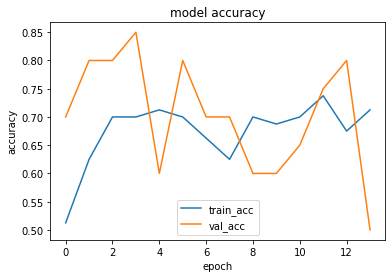

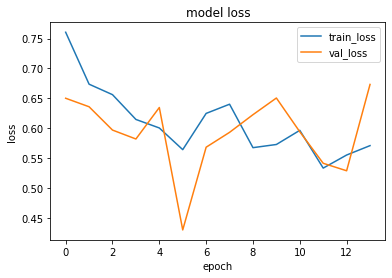

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.4504556]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_3.mov is [[0.43376958]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.58160055]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.41195142]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.3459804]]


1it [00:00, 14768.68it/s]


prediction for video control_3.mov is [[0.3724733]]
Epoch 1/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6907 - accuracy: 0.4875 - precision: 0.4853 - recall: 0.8462 - val_loss: 0.6481 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.2727
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6496 - accuracy: 0.7000 - precision: 0.7778 - recall: 0.5385 - val_loss: 0.6811 - val_accuracy: 0.6000 - val_precision: 0.6364 - val_recall: 0.6364
Epoch 3/75
3/3 [==============================] - 0s 134ms/step - loss: 0.5628 - accuracy: 0.7500 - precision: 0.7021 - recall: 0.8462 - val_loss: 0.7133 - val_accuracy: 0.6500 - val_precision: 0.6667 - val_recall: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.5519 - accuracy: 0.7250 - precision: 0.6809 - recall: 0.8205 - val_loss: 0.7321 - val_accuracy: 0.5000 - val_precision: 0.5556 - val_recall: 0.4545
Epoch 5/75
3/3 [==============================] - 0s 126ms/s

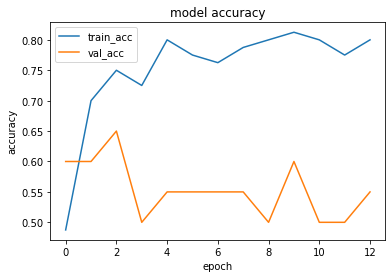

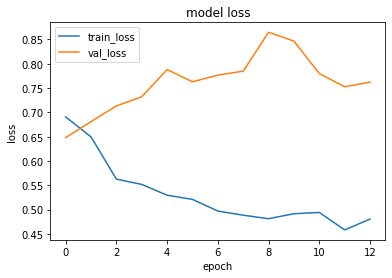

1it [00:00, 16980.99it/s]


prediction for video armflapping_1.mov is [[0.24245295]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_3.mov is [[0.45001826]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.69741726]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.21162897]]


1it [00:00, 17476.27it/s]


prediction for video control_2.mov is [[0.19221368]]


1it [00:00, 22192.08it/s]


prediction for video control_3.mov is [[0.22133142]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6790 - accuracy: 0.4750 - precision: 0.4706 - recall: 0.6154 - val_loss: 0.6531 - val_accuracy: 0.5500 - val_precision: 0.5500 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6868 - accuracy: 0.5750 - precision: 0.5439 - recall: 0.7949 - val_loss: 0.5986 - val_accuracy: 0.8000 - val_precision: 0.8889 - val_recall: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6312 - accuracy: 0.6625 - precision: 0.7000 - recall: 0.5385 - val_loss: 0.5602 - val_accuracy: 0.8000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.5841 - accuracy: 0.6750 - precision: 0.6585 - recall: 0.6923 - val_loss: 0.4874 - val_accuracy: 0.8000 - val_precision: 0.7333 - val_recall: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 120ms/

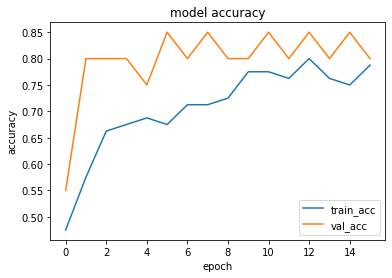

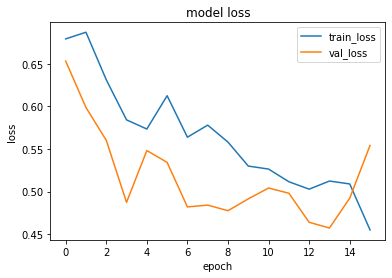

1it [00:00, 14217.98it/s]


prediction for video armflapping_1.mov is [[0.5394973]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_3.mov is [[0.32410914]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.43584272]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.45273298]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.35943198]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.36974525]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7342 - accuracy: 0.3625 - precision: 0.3958 - recall: 0.4634 - val_loss: 0.6353 - val_accuracy: 0.5000 - val_precision: 0.4706 - val_recall: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 118ms/step - loss: 0.7284 - accuracy: 0.5375 - precision: 0.5256 - recall: 1.0000 - val_loss: 0.6338 - val_accuracy: 0.5000 - val_precision: 0.4706 - val_recall: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6626 - accuracy: 0.6125 - precision: 0.5758 - recall: 0.9268 - val_loss: 0.6349 - val_accuracy: 0.7500 - val_precision: 0.8333 - val_recall: 0.5556
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6542 - accuracy: 0.6500 - precision: 0.7241 - recall: 0.5122 - val_loss: 0.6142 - val_accuracy: 0.9000 - val_precision: 0.8889 - val_recall: 0.8889
Epoch 5/75
3/3 [==============================] - 0s 180ms/

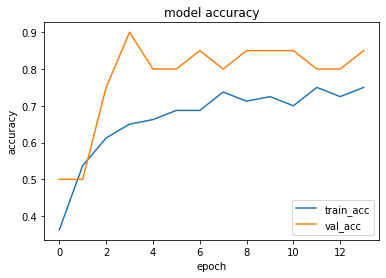

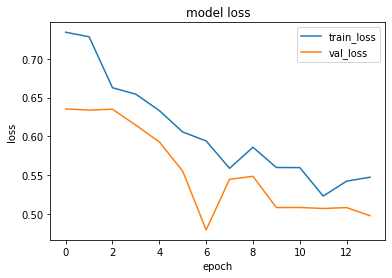

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.50643116]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.49405336]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.5311574]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.49003226]]


1it [00:00, 17924.38it/s]


prediction for video control_2.mov is [[0.48353827]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.48262605]]
Epoch 1/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6693 - accuracy: 0.5625 - precision: 0.6047 - recall: 0.5909 - val_loss: 0.9442 - val_accuracy: 0.3500 - val_precision: 0.3158 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6402 - accuracy: 0.6000 - precision: 0.5811 - recall: 0.9773 - val_loss: 0.6755 - val_accuracy: 0.7000 - val_precision: 0.5000 - val_recall: 0.3333
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6337 - accuracy: 0.6750 - precision: 0.8214 - recall: 0.5227 - val_loss: 0.6794 - val_accuracy: 0.6500 - val_precision: 0.4000 - val_recall: 0.3333
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6018 - accuracy: 0.7250 - precision: 0.7895 - recall: 0.6818 - val_loss: 0.7275 - val_accuracy: 0.6000 - val_precision: 0.3750 - val_recall: 0.5000
Epoch 5/75
3/3 [==============================] - 0s 126ms/

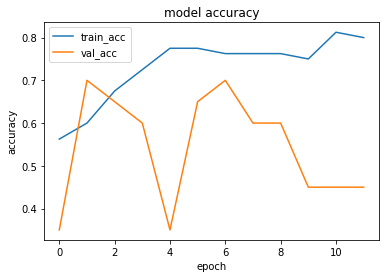

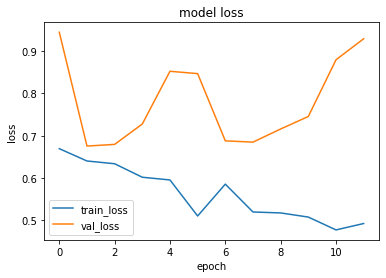

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.7034725]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.80809146]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.7921286]]


1it [00:00, 15420.24it/s]


prediction for video control_1.mov is [[0.09473673]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.08073989]]


1it [00:00, 12372.58it/s]


prediction for video control_3.mov is [[0.10259214]]


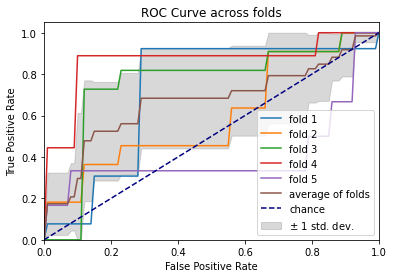

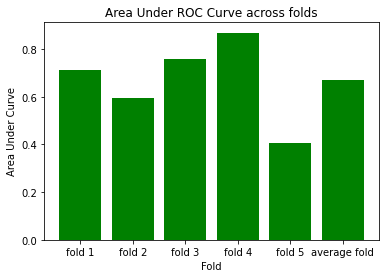

Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.7220 - accuracy: 0.5000 - precision: 0.5556 - recall: 0.3488 - val_loss: 0.7895 - val_accuracy: 0.3500 - val_precision: 0.3500 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6477 - accuracy: 0.5625 - precision: 0.5526 - recall: 0.9767 - val_loss: 0.7721 - val_accuracy: 0.3500 - val_precision: 0.3500 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6203 - accuracy: 0.6875 - precision: 0.6500 - recall: 0.9070 - val_loss: 0.7493 - val_accuracy: 0.4500 - val_precision: 0.3571 - val_recall: 0.7143
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5698 - accuracy: 0.7375 - precision: 0.7500 - recall: 0.7674 - val_loss: 1.0283 - val_accuracy: 0.5000 - val_precision: 0.4118 - val_recall: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6471 - accuracy: 0.6875 - precision: 0

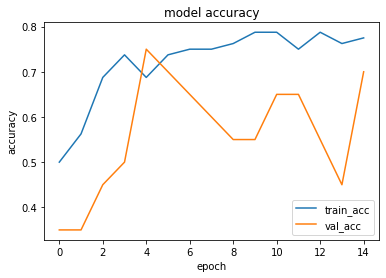

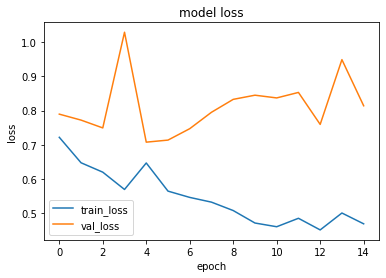

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.5304146]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.46518654]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_2.mov is [[0.62043226]]


1it [00:00, 13842.59it/s]


prediction for video control_1.mov is [[0.45646706]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.40284416]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.40450114]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6917 - accuracy: 0.4875 - precision: 0.5000 - recall: 0.7317 - val_loss: 0.7797 - val_accuracy: 0.4500 - val_precision: 0.4500 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 177ms/step - loss: 0.6696 - accuracy: 0.6250 - precision: 0.5873 - recall: 0.9024 - val_loss: 0.6600 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.6667
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6608 - accuracy: 0.6125 - precision: 0.6923 - recall: 0.4390 - val_loss: 0.6101 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 0.5556
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6246 - accuracy: 0.7000 - precision: 0.7297 - recall: 0.6585 - val_loss: 0.5899 - val_accuracy: 0.7000 - val_precision: 0.6154 - val_recall: 0.8889
Epoch 5/75
3/3 [==============================] - 0s 127ms/

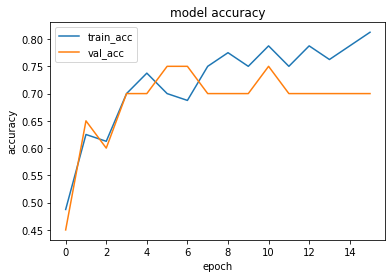

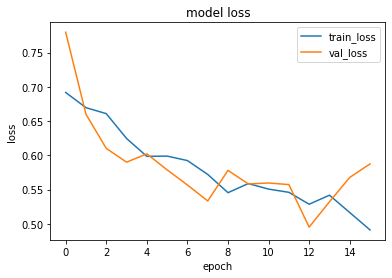

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.3594069]]


1it [00:00, 13934.56it/s]


prediction for video armflapping_3.mov is [[0.66445774]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.82542783]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.31376454]]


1it [00:00, 15827.56it/s]


prediction for video control_2.mov is [[0.3015054]]


1it [00:00, 13706.88it/s]


prediction for video control_3.mov is [[0.3032512]]
Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6834 - accuracy: 0.4625 - precision: 0.4510 - recall: 0.6053 - val_loss: 0.7987 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6674 - accuracy: 0.6000 - precision: 0.6154 - recall: 0.4211 - val_loss: 0.6610 - val_accuracy: 0.6000 - val_precision: 0.6667 - val_recall: 0.6667
Epoch 3/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6105 - accuracy: 0.7250 - precision: 0.6667 - recall: 0.8421 - val_loss: 0.6626 - val_accuracy: 0.7000 - val_precision: 0.8000 - val_recall: 0.6667
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5439 - accuracy: 0.7875 - precision: 0.7692 - recall: 0.7895 - val_loss: 0.7777 - val_accuracy: 0.6500 - val_precision: 0.7778 - val_recall: 0.5833
Epoch 5/75
3/3 [==============================] - 0s

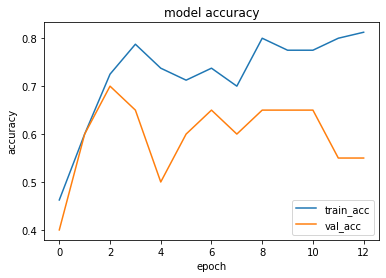

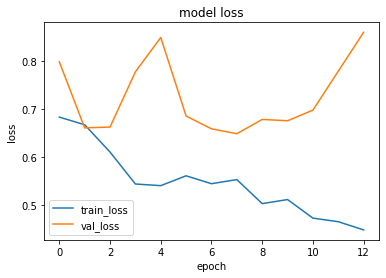

1it [00:00, 15196.75it/s]


prediction for video armflapping_1.mov is [[0.17325625]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_3.mov is [[0.18403259]]


1it [00:00, 14027.77it/s]


prediction for video armflapping_2.mov is [[0.20390269]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.16765362]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.16464949]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.16325596]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6584 - accuracy: 0.5750 - precision: 0.5306 - recall: 0.7027 - val_loss: 0.8893 - val_accuracy: 0.3500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6585 - accuracy: 0.6625 - precision: 0.7273 - recall: 0.4324 - val_loss: 0.5654 - val_accuracy: 0.7500 - val_precision: 0.8333 - val_recall: 0.7692
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6002 - accuracy: 0.6750 - precision: 0.6122 - recall: 0.8108 - val_loss: 0.6193 - val_accuracy: 0.7000 - val_precision: 0.8889 - val_recall: 0.6154
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5660 - accuracy: 0.7375 - precision: 0.7667 - recall: 0.6216 - val_loss: 0.6248 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.6154
Epoch 5/75
3/3 [==============================] - 0

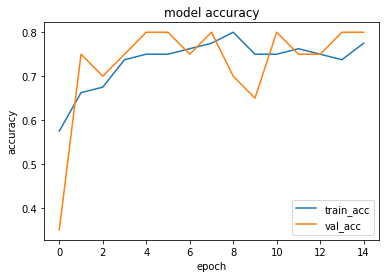

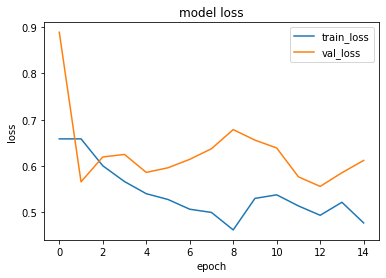

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.49081466]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_3.mov is [[0.61995816]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.6719295]]


1it [00:00, 16320.25it/s]


prediction for video control_1.mov is [[0.29868984]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.23664653]]


1it [00:00, 16710.37it/s]


prediction for video control_3.mov is [[0.2301166]]
Epoch 1/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6894 - accuracy: 0.5375 - precision: 0.5357 - recall: 0.7317 - val_loss: 0.5516 - val_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.9347 - accuracy: 0.5125 - precision: 0.5625 - recall: 0.2195 - val_loss: 0.6110 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.4444
Epoch 3/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6758 - accuracy: 0.5500 - precision: 0.5532 - recall: 0.6341 - val_loss: 0.6405 - val_accuracy: 0.4500 - val_precision: 0.4500 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.7170 - accuracy: 0.6000 - precision: 0.5672 - recall: 0.9268 - val_loss: 0.5954 - val_accuracy: 0.7000 - val_precision: 0.6154 - val_recall: 0.8889
Epoch 5/75
3/3 [==============================] - 0s 177ms/s

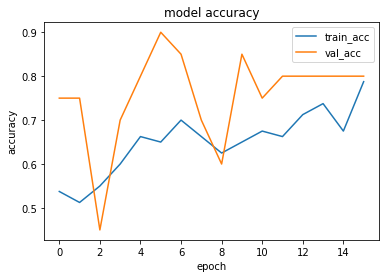

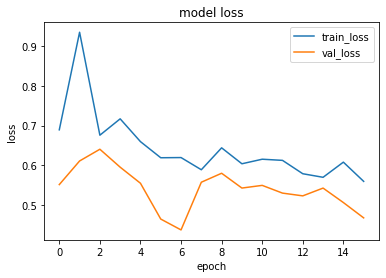

1it [00:00, 16320.25it/s]


prediction for video armflapping_1.mov is [[0.38243207]]


1it [00:00, 10727.12it/s]


prediction for video armflapping_3.mov is [[0.5217853]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.5081105]]


1it [00:00, 14873.42it/s]


prediction for video control_1.mov is [[0.21805474]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.18182826]]


1it [00:00, 13706.88it/s]

prediction for video control_3.mov is [[0.17743048]]


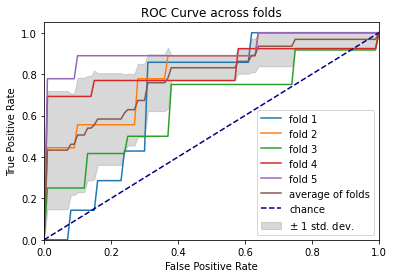

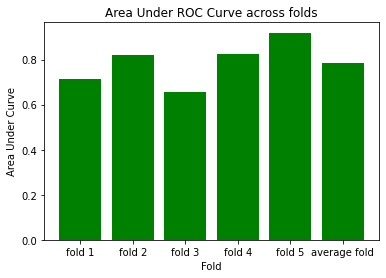

In [18]:
import numpy as np
import random
import tensorflow as tf
np.random.seed() 

SEEDS = [random.randrange(0, 100) for i in range(10)]
for seed in SEEDS:
    X, y = shuffle(original_X, original_Y, seed=seed)

    # run it 5 times for each seed 
    checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
    cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

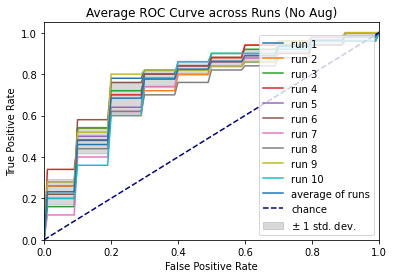

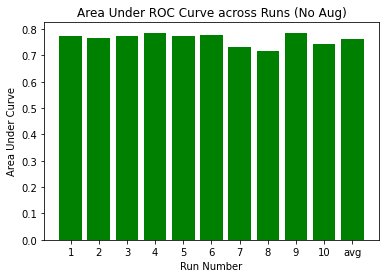

In [ ]:
# REEE RUN THIS STUFF 
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, np.linspace(0, 1, 101)) # save the images here 

In [ ]:
np.mean(AVERAGE_AUROCS), np.std(AVERAGE_AUROCS)

(0.7629999999999999, 0.021713004063338297)

In [ ]:
def interpret(metrics_string):
     metrics = []
     for i in range(len(metrics_string)):
         try:
             index = metrics_string.index(":")
             metrics.append(metrics_string[index + 2 : index + 8])
             metrics_string = metrics_string[index + 9:]
         except Exception as e:
             return [float(m) for m in metrics][1:]

In [ ]:
METRICS = [] # training acc, training pres, training recall, validation acc, validation pres, validation recall 

# for all of the 50 runs have a (50, 6 + 2) matrix, and then use that to store data and compute scores 
import numpy as np
meta_results = []
meta_results.append("3/3 [==============================] - 0s 143ms/step - loss: 0.5490 - accuracy: 0.7625 - precision_127: 0.7692 - recall_127: 0.7500 - val_loss: 0.6196 - val_accuracy: 0.7000 - val_precision_127: 0.6429 - val_recall_127: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5468 - accuracy: 0.7500 - precision_128: 0.7381 - recall_128: 0.7750 - val_loss: 0.4929 - val_accuracy: 0.7500 - val_precision_128: 0.7778 - val_recall_128: 0.7000")
meta_results.append("3/3 [==============================] - 0s 148ms/step - loss: 0.5195 - accuracy: 0.7875 - precision_129: 0.8485 - recall_129: 0.7000 - val_loss: 0.6768 - val_accuracy: 0.6500 - val_precision_129: 0.7143 - val_recall_129: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5528 - accuracy: 0.7375 - precision_130: 0.8800 - recall_130: 0.5500 - val_loss: 0.6188 - val_accuracy: 0.7000 - val_precision_130: 0.7500 - val_recall_130: 0.6000")
meta_results.append("3/3 [==============================] - 0s 136ms/step - loss: 0.5276 - accuracy: 0.7500 - precision_131: 0.7500 - recall_131: 0.7500 - val_loss: 0.5546 - val_accuracy: 0.7500 - val_precision_131: 0.7778 - val_recall_131: 0.7000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.3641 - accuracy: 0.8250 - precision_133: 0.9333 - recall_133: 0.7000 - val_loss: 0.8364 - val_accuracy: 0.7000 - val_precision_133: 0.6429 - val_recall_133: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5302 - accuracy: 0.7750 - precision_134: 0.7750 - recall_134: 0.7750 - val_loss: 0.5209 - val_accuracy: 0.8000 - val_precision_134: 0.8000 - val_recall_134: 0.8000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5198 - accuracy: 0.7375 - precision_135: 0.7209 - recall_135: 0.7750 - val_loss: 0.6696 - val_accuracy: 0.5500 - val_precision_135: 0.5714 - val_recall_135: 0.4000")
meta_results.append('3/3 [==============================] - 0s 142ms/step - loss: 0.5037 - accuracy: 0.7875 - precision_136: 0.8108 - recall_136: 0.7500 - val_loss: 0.5018 - val_accuracy: 0.7500 - val_precision_136: 0.7273 - val_recall_136: 0.8000')
meta_results.append("3/3 [==============================] - 0s 128ms/step - loss: 0.6638 - accuracy: 0.6000 - precision_137: 0.6053 - recall_137: 0.5750 - val_loss: 0.6271 - val_accuracy: 0.6000 - val_precision_137: 0.6250 - val_recall_137: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4704 - accuracy: 0.7875 - precision_139: 0.8485 - recall_139: 0.7000 - val_loss: 0.6656 - val_accuracy: 0.7000 - val_precision_139: 0.6667 - val_recall_139: 0.8000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.6160 - accuracy: 0.6500 - precision_140: 0.6875 - recall_140: 0.5500 - val_loss: 0.5326 - val_accuracy: 0.8500 - val_precision_140: 0.8182 - val_recall_140: 0.9000")
meta_results.append("3/3 [==============================] - 0s 134ms/step - loss: 0.4795 - accuracy: 0.7625 - precision_141: 0.7838 - recall_141: 0.7250 - val_loss: 0.7107 - val_accuracy: 0.6500 - val_precision_141: 0.8000 - val_recall_141: 0.4000")
meta_results.append("3/3 [==============================] - 0s 121ms/step - loss: 0.5433 - accuracy: 0.7375 - precision_142: 0.9130 - recall_142: 0.5250 - val_loss: 0.5958 - val_accuracy: 0.7000 - val_precision_142: 0.7000 - val_recall_142: 0.7000")
meta_results.append("3/3 [==============================] - 0s 181ms/step - loss: 0.4387 - accuracy: 0.8375 - precision_143: 0.9091 - recall_143: 0.7500 - val_loss: 0.8756 - val_accuracy: 0.7000 - val_precision_143: 0.6429 - val_recall_143: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5071 - accuracy: 0.7750 - precision_145: 0.8235 - recall_145: 0.7000 - val_loss: 0.6108 - val_accuracy: 0.7000 - val_precision_145: 0.6429 - val_recall_145: 0.9000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4103 - accuracy: 0.7875 - precision_146: 0.7674 - recall_146: 0.8250 - val_loss: 0.6352 - val_accuracy: 0.7500 - val_precision_146: 0.7273 - val_recall_146: 0.8000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5201 - accuracy: 0.7375 - precision_147: 0.8065 - recall_147: 0.6250 - val_loss: 0.7552 - val_accuracy: 0.5500 - val_precision_147: 0.6000 - val_recall_147: 0.3000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4809 - accuracy: 0.7750 - precision_148: 0.7750 - recall_148: 0.7750 - val_loss: 0.5301 - val_accuracy: 0.7500 - val_precision_148: 0.7273 - val_recall_148: 0.8000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.6238 - accuracy: 0.7250 - precision_149: 0.6957 - recall_149: 0.8000 - val_loss: 0.5609 - val_accuracy: 0.7000 - val_precision_149: 0.7500 - val_recall_149: 0.6000")
meta_results.append("3/3 [==============================] - 0s 147ms/step - loss: 0.4444 - accuracy: 0.8125 - precision_151: 0.8571 - recall_151: 0.7500 - val_loss: 0.6537 - val_accuracy: 0.7000 - val_precision_151: 0.6667 - val_recall_151: 0.8000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4550 - accuracy: 0.8000 - precision_152: 0.7500 - recall_152: 0.9000 - val_loss: 0.6105 - val_accuracy: 0.7500 - val_precision_152: 0.7778 - val_recall_152: 0.7000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.4810 - accuracy: 0.7625 - precision_153: 0.8000 - recall_153: 0.7000 - val_loss: 0.6956 - val_accuracy: 0.6500 - val_precision_153: 0.7143 - val_recall_153: 0.5000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.4951 - accuracy: 0.7625 - precision_154: 0.7692 - recall_154: 0.7500 - val_loss: 0.5621 - val_accuracy: 0.7500 - val_precision_154: 0.7273 - val_recall_154: 0.8000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4192 - accuracy: 0.8250 - precision_155: 0.8421 - recall_155: 0.8000 - val_loss: 0.5144 - val_accuracy: 0.7500 - val_precision_155: 0.7778 - val_recall_155: 0.7000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.5146 - accuracy: 0.7375 - precision_157: 0.7568 - recall_157: 0.7000 - val_loss: 0.6470 - val_accuracy: 0.7000 - val_precision_157: 0.6429 - val_recall_157: 0.9000")
meta_results.append("3/3 [==============================] - 0s 136ms/step - loss: 0.5297 - accuracy: 0.7750 - precision_158: 0.7895 - recall_158: 0.7500 - val_loss: 0.5801 - val_accuracy: 0.7500 - val_precision_158: 0.7778 - val_recall_158: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4522 - accuracy: 0.7750 - precision_159: 0.8056 - recall_159: 0.7250 - val_loss: 0.6115 - val_accuracy: 0.6000 - val_precision_159: 0.7500 - val_recall_159: 0.3000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.5559 - accuracy: 0.7250 - precision_160: 0.6957 - recall_160: 0.8000 - val_loss: 0.5596 - val_accuracy: 0.7000 - val_precision_160: 0.6667 - val_recall_160: 0.8000")
meta_results.append("3/3 [==============================] - 0s 175ms/step - loss: 0.5519 - accuracy: 0.7750 - precision_161: 0.8438 - recall_161: 0.6750 - val_loss: 0.5466 - val_accuracy: 0.6500 - val_precision_161: 0.7143 - val_recall_161: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4980 - accuracy: 0.7750 - precision_163: 0.8235 - recall_163: 0.7000 - val_loss: 0.6757 - val_accuracy: 0.6500 - val_precision_163: 0.6154 - val_recall_163: 0.8000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4898 - accuracy: 0.7750 - precision_164: 0.7895 - recall_164: 0.7500 - val_loss: 0.6056 - val_accuracy: 0.7000 - val_precision_164: 0.7000 - val_recall_164: 0.7000")
meta_results.append("3/3 [==============================] - 0s 181ms/step - loss: 0.5320 - accuracy: 0.7375 - precision_165: 0.7209 - recall_165: 0.7750 - val_loss: 0.7340 - val_accuracy: 0.6500 - val_precision_165: 0.6364 - val_recall_165: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4484 - accuracy: 0.7750 - precision_166: 0.7895 - recall_166: 0.7500 - val_loss: 0.5302 - val_accuracy: 0.7500 - val_precision_166: 0.7273 - val_recall_166: 0.8000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.6792 - accuracy: 0.6750 - precision_167: 0.6522 - recall_167: 0.7500 - val_loss: 0.6917 - val_accuracy: 0.5500 - val_precision_167: 0.5556 - val_recall_167: 0.5000")
meta_results.append("3/3 [==============================] - 0s 128ms/step - loss: 0.4365 - accuracy: 0.8125 - precision_169: 0.8788 - recall_169: 0.7250 - val_loss: 0.7150 - val_accuracy: 0.6500 - val_precision_169: 0.6364 - val_recall_169: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5207 - accuracy: 0.7750 - precision_170: 0.7750 - recall_170: 0.7750 - val_loss: 0.5656 - val_accuracy: 0.7500 - val_precision_170: 0.7778 - val_recall_170: 0.7000")
meta_results.append("3/3 [==============================] - 0s 131ms/step - loss: 0.4846 - accuracy: 0.7625 - precision_171: 0.7692 - recall_171: 0.7500 - val_loss: 0.7023 - val_accuracy: 0.6500 - val_precision_171: 0.6667 - val_recall_171: 0.6000")
meta_results.append("3/3 [==============================] - 0s 129ms/step - loss: 0.4192 - accuracy: 0.8250 - precision_172: 0.8824 - recall_172: 0.7500 - val_loss: 0.8445 - val_accuracy: 0.7000 - val_precision_172: 0.7500 - val_recall_172: 0.6000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.6846 - accuracy: 0.5750 - precision_173: 0.5682 - recall_173: 0.6250 - val_loss: 0.6460 - val_accuracy: 0.6000 - val_precision_173: 0.6250 - val_recall_173: 0.5000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4731 - accuracy: 0.7625 - precision_175: 0.7838 - recall_175: 0.7250 - val_loss: 0.6003 - val_accuracy: 0.7500 - val_precision_175: 0.6923 - val_recall_175: 0.9000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.6343 - accuracy: 0.6875 - precision_176: 0.6744 - recall_176: 0.7250 - val_loss: 0.6167 - val_accuracy: 0.7000 - val_precision_176: 1.0000 - val_recall_176: 0.4000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.6491 - accuracy: 0.5875 - precision_177: 0.6061 - recall_177: 0.5000 - val_loss: 0.6270 - val_accuracy: 0.6000 - val_precision_177: 1.0000 - val_recall_177: 0.2000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4416 - accuracy: 0.8000 - precision_178: 0.8333 - recall_178: 0.7500 - val_loss: 0.6544 - val_accuracy: 0.6500 - val_precision_178: 0.7143 - val_recall_178: 0.5000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4658 - accuracy: 0.8125 - precision_179: 0.9032 - recall_179: 0.7000 - val_loss: 0.6116 - val_accuracy: 0.7500 - val_precision_179: 0.7778 - val_recall_179: 0.7000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4735 - accuracy: 0.8000 - precision_181: 0.8750 - recall_181: 0.7000 - val_loss: 0.6479 - val_accuracy: 0.6500 - val_precision_181: 0.6667 - val_recall_181: 0.6000")
meta_results.append("3/3 [==============================] - 0s 153ms/step - loss: 0.5056 - accuracy: 0.7750 - precision_182: 0.7895 - recall_182: 0.7500 - val_loss: 0.4801 - val_accuracy: 0.7500 - val_precision_182: 0.7778 - val_recall_182: 0.7000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4631 - accuracy: 0.8000 - precision_183: 0.8000 - recall_183: 0.8000 - val_loss: 0.7841 - val_accuracy: 0.5000 - val_precision_183: 0.5000 - val_recall_183: 0.3000")
meta_results.append("3/3 [==============================] - 0s 129ms/step - loss: 0.4344 - accuracy: 0.8500 - precision_184: 0.8684 - recall_184: 0.8250 - val_loss: 0.6026 - val_accuracy: 0.7000 - val_precision_184: 0.6667 - val_recall_184: 0.8000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.5167 - accuracy: 0.7375 - precision_185: 0.7111 - recall_185: 0.8000 - val_loss: 0.5716 - val_accuracy: 0.7000 - val_precision_185: 0.7500 - val_recall_185: 0.6000")

METRICS = [interpret(result) for result in meta_results]

In [ ]:
METRICS = np.array(METRICS)

METRICS = np.delete(METRICS, obj=3, axis=1)
METRICS.shape

(50, 6)

In [ ]:
train_acc = METRICS[:, 0]
train_pres = METRICS[:, 1]
train_recall = METRICS[:, 2]
val_acc = METRICS[:, 3]
val_pres = METRICS[:, 4]
val_recall = METRICS[:, 5]

print(f"training accuracy : {round(train_acc.mean(), 3)} ± {round(train_acc.std(), 3)}")
print(f"training precision : {round(train_pres.mean(), 3)} ± {round(train_pres.std(), 3)}")
print(f"training recall : {round(train_recall.mean(), 3)} ± {round(train_recall.std(), 3)}")
print(f"validation accuracy : {round(val_acc.mean(), 3)} ± {round(val_acc.std(), 3)}")
print(f"validation precision : {round(val_pres.mean(), 3)} ± {round(val_pres.std(), 3)}")
print(f"validation recall : {round(val_recall.mean(), 3)} ± {round(val_recall.std(), 3)}")


training accuracy : 0.759 ± 0.058
training precision : 0.785 ± 0.081
training recall : 0.725 ± 0.078
validation accuracy : 0.688 ± 0.068
validation precision : 0.711 ± 0.091
validation recall : 0.658 ± 0.181


In [ ]:
def hmean(pres, recall):
    return 2 * pres * recall / (pres + recall)

train_f1 = hmean(train_pres, train_recall)
val_f1 = hmean(val_pres, val_recall)
print(f"training F1 : {round(train_f1.mean(), 3)} ± {round(train_f1.std(), 3)}")
print(f"validation F1 : {round(val_f1.mean(), 3)} ± {round(val_f1.std(), 3)}")

training F1 : 0.75 ± 0.06
validation F1 : 0.665 ± 0.115


In [ ]:
METRICS_DICT = {i : [] for i in range(5)}

for i, metric in enumerate(METRICS): 
    METRICS_DICT[i % 5].append(metric)

for i, value in METRICS_DICT.items():
    METRICS_DICT[i] = np.array(METRICS_DICT[i])

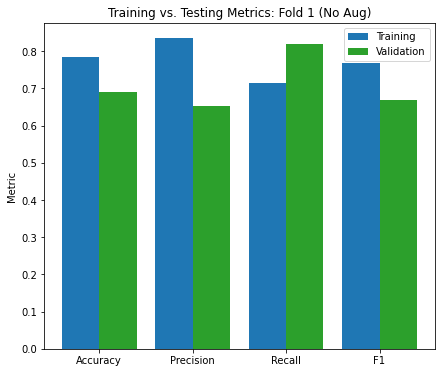

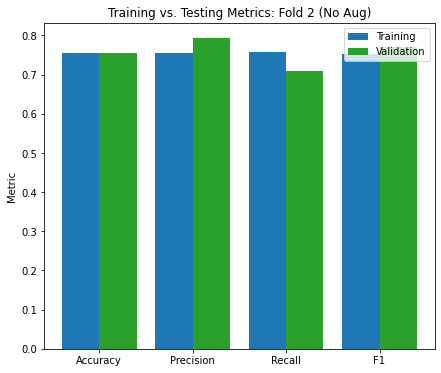

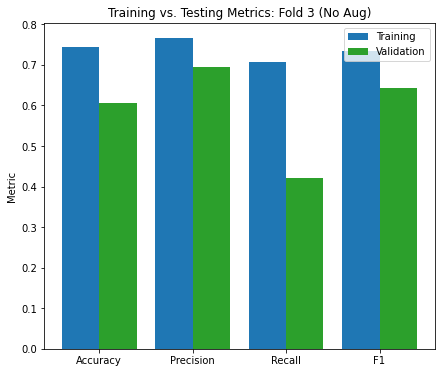

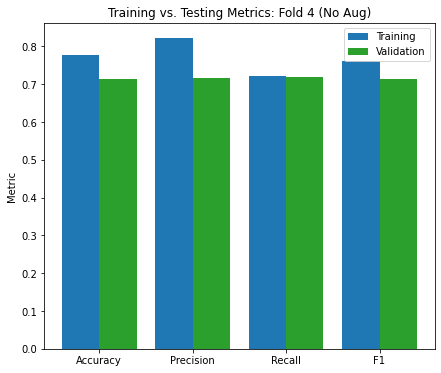

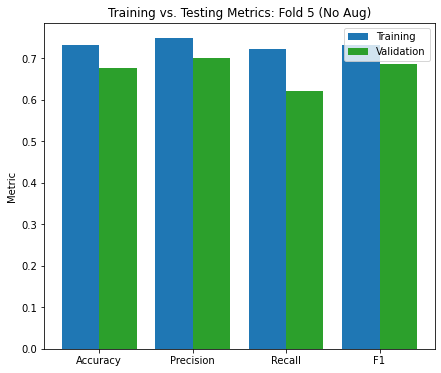

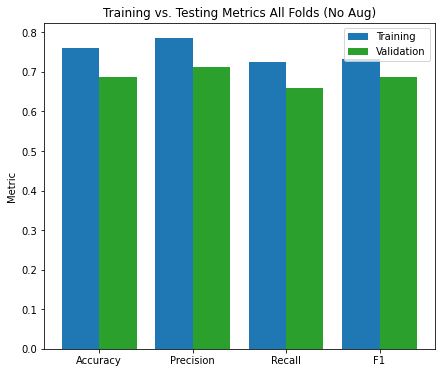

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for FOLD_NUMBER in range(6): 
    
    if FOLD_NUMBER == 5: 
        training_acc = round(METRICS[:, 0].mean(), 3)
        training_precision = round(METRICS[:, 1].mean(), 3)
        training_recall = round(METRICS[:, 2].mean(), 3)
        validation_acc = round(METRICS[:, 3].mean(), 3)
        validation_precision = round(METRICS[:, 4].mean(), 3)
        validation_recall = round(METRICS[:, 5].mean(), 3)

        train_f1 = hmean(training_precision, train_recall)
        val_f1 = hmean(validation_precision, validation_recall)
    
    else : 
        metrics = METRICS_DICT[FOLD_NUMBER]
        training_acc = round(metrics[:, 0].mean(), 3)
        training_precision = round(metrics[:, 1].mean(), 3)
        training_recall = round(metrics[:, 2].mean(), 3)
        validation_acc = round(metrics[:, 3].mean(), 3)
        validation_precision = round(metrics[:, 4].mean(), 3)
        validation_recall = round(metrics[:, 5].mean(), 3)


        training_f1 = hmean(metrics[:, 1], metrics[:, 2]).mean()
        validation_f1 = hmean(metrics[:, 3], metrics[:, 4]).mean()

    labels = ['Accuracy', "Precision", "Recall", "F1"]

    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(7, 6)
    rects1 = ax.bar(x - width/2, [training_acc, training_precision, training_recall, training_f1], width, label='Training', color = "tab:blue")
    rects2 = ax.bar(x + width/2, [validation_acc, validation_precision, validation_recall, validation_f1], width, label='Validation', color="tab:green")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Metric')
    if FOLD_NUMBER != 5: 
        ax.set_title(f"Training vs. Testing Metrics: Fold {FOLD_NUMBER + 1} (No Aug)")
    else: 
        ax.set_title("Training vs. Testing Metrics All Folds (No Aug)")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc="upper right")

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    if FOLD_NUMBER != 5 : 
        plt.savefig(f"balanced_plots/train_vs_test_{FOLD_NUMBER + 1}_naug.png")

    else: 
        plt.savefig("balanced_plots/train_vs_test_all_naug.png")
    plt.show()